# Imports

In [1]:
!pip install tensorflow
import pandas as pd
from scipy.interpolate import interp1d
from scipy .integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential, Model
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, Callback
from keras import Loss
from keras.saving import custom_object_scope
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 542.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.6 MB/s eta 0:00:00


# Train on single vehicle dynamics

## Constant coefficient car

trapezoidal rule (implicit):
\begin{equation}
\frac{v_{k+1}-v_{k}}{\Delta_t} = \frac{f(v_{k+1}) + f(v_k)}{2} = \frac{a_{k+1} + a_k}{2}
\end{equation}
$v_{k+1}$ and $f(v_{k+1})$ or $a_{k+1}$ form a circular dependency -> not possible for real-time simulation

Euler on the other hand (explicit):
\begin{equation}
\frac{v_{k+1}-v_{k}}{\Delta_t} = f(v_k)
\end{equation}

Fixed step Runge kutta could also work but then I would need to call f() more than one time which is not worth it for the prediction later

In [2]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate
        self.x0 = x0
        self.X = np.array(self.x0, dtype=np.float32) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }


    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""

        v_k, a_k = self._dynamics(self.X, u)

        #store current state to history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)
        self.history["a"].append(a_k)

        self.X[0] += v_k*dt
        self.X[1] += a_k*dt

        return self.X

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        #return np.array([v,a])
        return (v, a)

    def reset(self, x0):
        del self.history
        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }
        self.X = np.array(x0, dtype=np.float32) #[position, velocity]


## Generate synthetic data

   traj_id    t      u   v_meas_m    x_meas    a_true   v_true_m  v_true_km  \
0      0.0  0.0  510.0  13.867029  0.097047 -0.000861  13.888889  50.000000   
1      0.0  0.1  510.0  13.812484  1.471493 -0.000861  13.888803  49.999691   
2      0.0  0.2  510.0  13.811006  2.722669 -0.000860  13.888718  49.999382   
3      0.0  0.3  510.0  14.073567  4.217605 -0.000859  13.888632  49.999073   
4      0.0  0.4  510.0  13.817986  5.532927 -0.000859  13.888546  49.998764   

     x_true  a_true_shift  v_true_shift_m  x_true_shift  
0  0.000000     -0.000861       13.888803      1.388889  
1  1.388889     -0.000860       13.888718      2.777769  
2  2.777769     -0.000859       13.888632      4.166641  
3  4.166641     -0.000859       13.888546      5.555504  
4  5.555504     -0.000858       13.888460      6.944359  


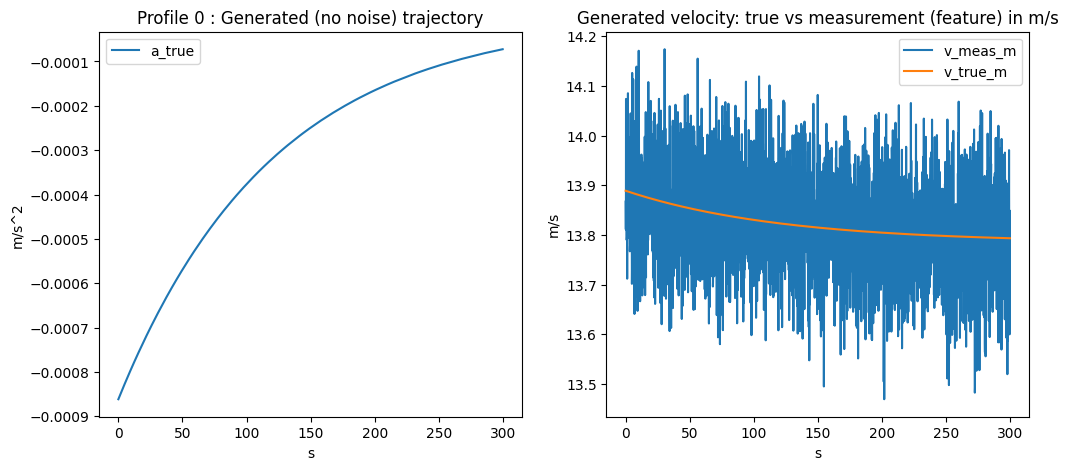

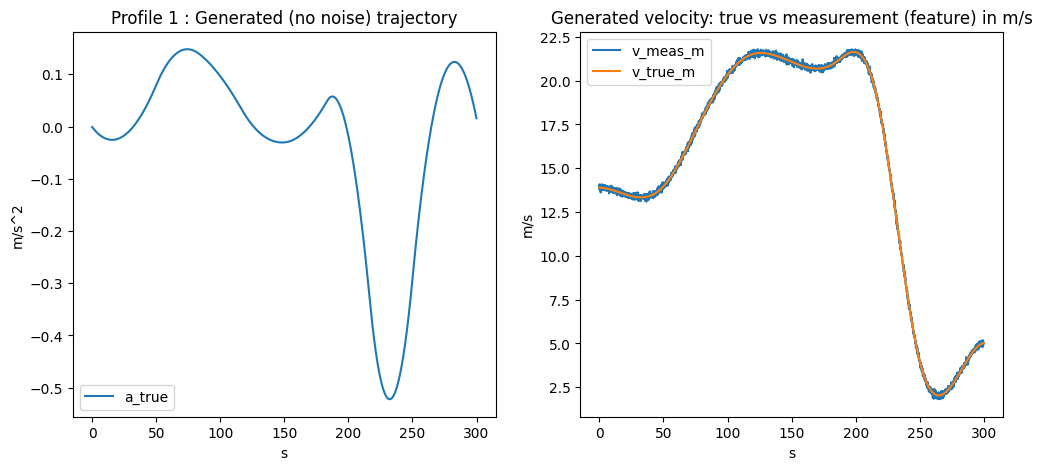

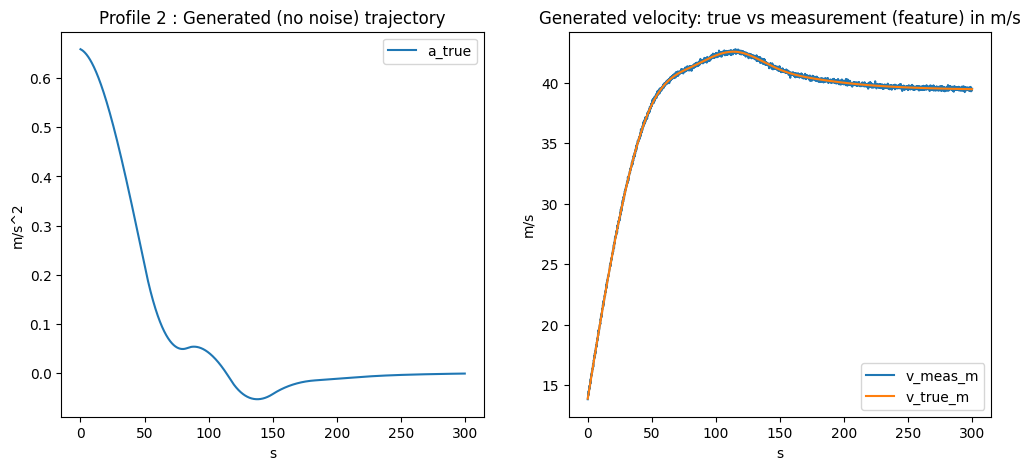

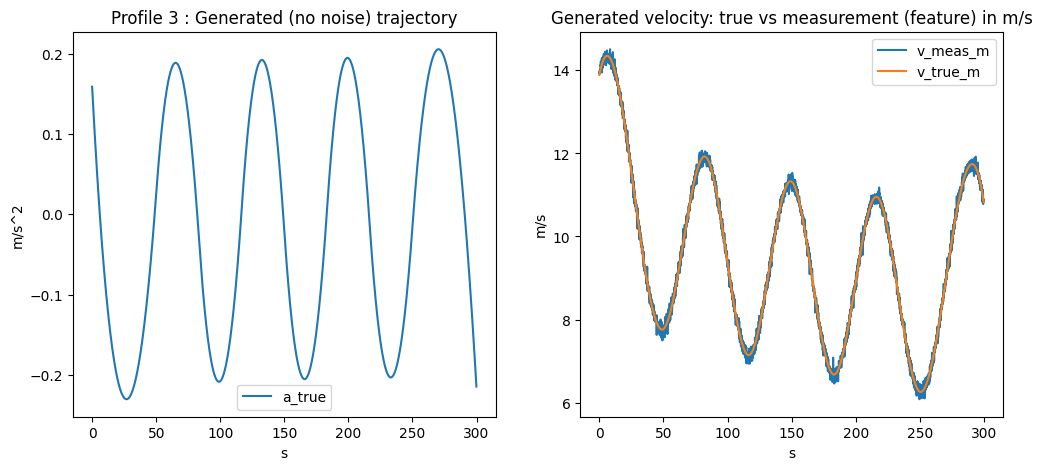

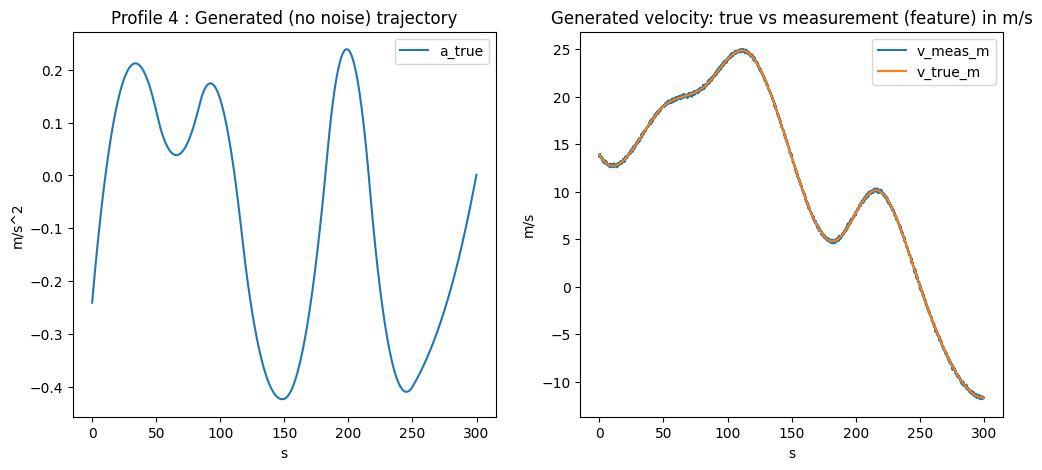

In [4]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
v0 = 50/3.6
x0 = (0, v0) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)
t_samp = np.linspace(0, t_end, 10, dtype=np.float32)
std = 1e-1

#DEFINE U PROFILES
input_profiles = []
input_profiles.append(np.full_like(t_samp, 0.34, dtype=np.float32) * m) #crusing
input_profiles.append(np.array([0.34, 0.34, 0.5, 0.5, 0.4, 0.4, 0.4, -0.2, 0.3, 0.3], dtype=np.float32) * m) #emerg braking
input_profiles.append(np.array([1.0, 1.0, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7], dtype=np.float32) * m) #accelerating
input_profiles.append(np.array([0.5, 0.1]*5, dtype=np.float32) * m) #stop&go/oscillating
np.random.seed(31)
input_profiles.append(np.random.uniform(low=-0.1, high=0.6, size=t_samp.shape).astype(np.float32) * m) #random

input_interp = []
for profile in input_profiles:
    input_interp.append(interp1d(t_samp, profile, kind='quadratic'))

#simulate and build dataframes
def simulate_traj(car, u_func, traj_id, t):
    for t_curr in t:
        car.update(u_func(t_curr), dt)
    data = {
        'traj_id': traj_id,
        't': t,
        'u': car.history["u"],
        'v_meas_m': np.array(car.history["v"]) + np.random.normal(loc=0, scale=std, size=len(t)),
        'x_meas': np.array(car.history["x"]) + np.random.normal(loc=0, scale=std, size=len(t)),
        'a_true': car.history["a"],
        'v_true_m': car.history["v"],
        "v_true_km": np.array(car.history["v"])*3.6,
        'x_true': car.history["x"],
    }

    df = pd.DataFrame(data, dtype=np.float32)
    #label/output is next step acceleration
    df[["a_true_shift", "v_true_shift_m", "x_true_shift"]] = df[["a_true", "v_true_m", "x_true"]].shift(-1, fill_value=np.nan)
    df = df.dropna(axis=0) #drop last row (NA)
    return df

dataframes = []
for id, func in enumerate(input_interp):
    dataframe = simulate_traj(car, func, id, t)

    #plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    dataframe.plot(x='t', y="a_true", ax=axs[0],
               title="Profile " + str(id) + " : Generated (no noise) trajectory",
               legend=True, ylabel="m/s^2", xlabel="s")
    dataframe.plot(x='t', y=["v_meas_m","v_true_m"], ax=axs[1],
               title="Generated velocity: true vs measurement (feature) in m/s",
               legend=True, ylabel="m/s", xlabel="s")

    dataframes.append(dataframe)
    car.reset(x0) #x0 common for all trajectories

t = t[:-1] #drop last row
dataset = pd.concat(dataframes, axis=0, ignore_index=True)
dataset.to_csv("data/synthetic_5_trajectories.csv", index=False)
print(dataset.head())

## Helper funcs

In [5]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str, meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''

    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for acceleration:
    plt.subplot(1, 3, 1)
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 3, 2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()


    plt.subplot(1, 3, 3)
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history, es_start_epoch):
    loss = history["loss"]
    val_loss = history["val_loss"]
    best_epoch = es_start_epoch + np.argmin(val_loss[es_start_epoch:]) + 1

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    #add a marker for the early stopping epoch
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Restored')
    plt.text(best_epoch, val_loss[best_epoch - 1], f'({best_epoch}, {val_loss[best_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(model, X_norm, true_data):
    v = np.zeros_like(t)
    x = np.zeros_like(t)

    pred_a = model.predict(X_norm)
    print(X_norm.shape[0])
    v = np.cumsum(pred_a.flatten() * dt)
    v += x0[1]
    x = np.cumsum(v*dt)
    x += x0[0]

    mse_a = mean_squared_error(true_data[:, 0], pred_a)
    mse_v = mean_squared_error(true_data[:, 1], v)
    mse_x = mean_squared_error(true_data[:, 2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

**for now only using one of the trajectories for training although I had made a tf.dataset that would have shape (traj, N, features) for parallel training. But that would require changing the models architecture as far as I know for now. Stash that**

Number of training points:
(300, 3)


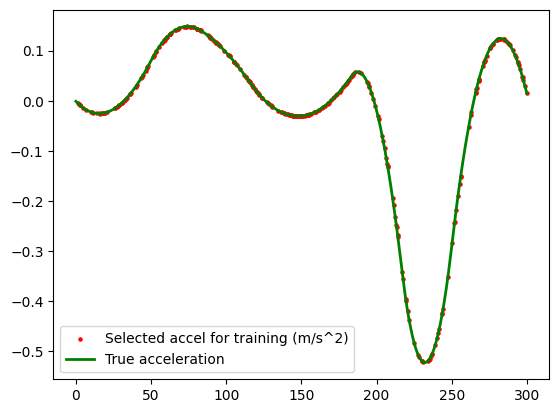

' # Plot histograms for features and outputs using seaborn\nfig, ax = plt.subplots(1, 2, figsize=(12, 5))\nfig.suptitle("After normalization")\n\n# Plot histograms for features\nsns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color=\'blue\')\nax[0].set_title(\'Histogram of Feature t (training)\')\nax[0].set_xlabel(\'t\')\nax[0].set_ylabel(\'Frequency\')\n\nsns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color=\'green\')\nax[1].set_title(\'Histogram of Feature u (training)\')\nax[1].set_xlabel(\'u\')\nax[1].set_ylabel(\'Frequency\')\n\n# Plot histogram for output\nplt.figure(figsize=(6, 5))\nsns.histplot(Y_train, bins=100, kde=True, color=\'orange\')\nplt.title(\'Histogram of Acceleration (training)\')\nplt.xlabel(\'Acceleration\')\nplt.ylabel(\'Frequency\')\n\nplt.tight_layout()\nplt.show() '

In [28]:
train_ratio = .1 #data sparsity
train_id = 1 #traj id
test_id = 0

df_train_traj = dataset[dataset['traj_id'] == train_id]
df_test_traj = dataset[dataset['traj_id'] == test_id]
X = df_train_traj[["t", "u", "v_true_m", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N
X_test = df_test_traj[["t", "u", "v_true_m", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N

Y_train_traj = df_train_traj[["a_true_shift", "v_true_shift_m", "x_true_shift"]].to_numpy()  #includes v and p but NN only predicts a
Y_test_traj = df_test_traj[["a_true_shift", "v_true_shift_m", "x_true_shift"]].to_numpy()
y0_true = Y_train_traj[0,:]
Y_train, Y_val, X_train, X_val = train_test_split(Y_train_traj, X, train_size=train_ratio, random_state=31)
print("Number of training points:")
print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_train_traj[:,0], Y_train)
Y_mask = Y_train_traj[:,0].copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_mask, label="Selected accel for training (m/s^2)", s=5, color="red")
plt.plot(t, Y_train_traj[:,0], label="True acceleration", linewidth=2, color="green")
plt.legend()
plt.show()

""" #Prediction Normalization
# not doing this now
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)
Y_true_norm = scaler_Y.transform(Y_true)
y_0_norm = Y_true_norm[0, :] """

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x0_norm = X_norm[0, :]

""" # Plot histograms for features and outputs using seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("After normalization")

# Plot histograms for features
sns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Histogram of Feature t (training)')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Frequency')

sns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color='green')
ax[1].set_title('Histogram of Feature u (training)')
ax[1].set_xlabel('u')
ax[1].set_ylabel('Frequency')

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train, bins=100, kde=True, color='orange')
plt.title('Histogram of Acceleration (training)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show() """

# PUNN-only

Epoch 1/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.0387

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0338 - val_loss: 0.0259 - learning_rate: 1.0000e-04
Epoch 2/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0243

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0223 - val_loss: 0.0167 - learning_rate: 1.0000e-04
Epoch 3/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0128

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0135 - val_loss: 0.0127 - learning_rate: 1.0000e-04
Epoch 4/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0106

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0105 - val_loss: 0.0097 - learning_rate: 1.0000e-04
Epoch 5/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0062

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0082 - val_loss: 0.0079 - learning_rate: 1.0000e-04
Epoch 6/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0045

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0063 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 7/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0060

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0058 - val_loss: 0.0059 - learning_rate: 1.0000e-04
Epoch 8/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0049

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0045 - val_loss: 0.0052 - learning_rate: 1.0000e-04
Epoch 9/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0048

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0043 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 10/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0031

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0037 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 11/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0028

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0034 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 12/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0023

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0030 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 13/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0040

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 14/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0037

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 15/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0032

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - val_loss: 0.0028 - learning_rate: 1.0000e-04
Epoch 16/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0027

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0025 - val_loss: 0.0025 - learning_rate: 1.0000e-04
Epoch 17/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0020

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 18/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0022

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 19/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 20/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0016

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 21/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0012

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0014 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 22/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0012

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 23/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 24/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 25/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 7.6420e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0786e-04 - val_loss: 9.4586e-04 - learning_rate: 1.0000e-04
Epoch 26/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.4654e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6878e-04 - val_loss: 8.7657e-04 - learning_rate: 1.0000e-04
Epoch 27/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.2859e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.0212e-04 - val_loss: 7.3720e-04 - learning_rate: 1.0000e-04
Epoch 28/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.9122e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.8853e-04 - val_loss: 6.5195e-04 - learning_rate: 1.0000e-04
Epoch 29/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.3956e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9172e-04 - val_loss: 5.7948e-04 - learning_rate: 1.0000e-04
Epoch 30/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.3727e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.0461e-04 - val_loss: 5.0661e-04 - learning_rate: 1.0000e-04
Epoch 31/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.2031e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.1513e-04 - val_loss: 4.4352e-04 - learning_rate: 1.0000e-04
Epoch 32/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.3171e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.7103e-04 - val_loss: 3.8702e-04 - learning_rate: 1.0000e-04
Epoch 33/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.3519e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7863e-04 - val_loss: 3.4623e-04 - learning_rate: 1.0000e-04
Epoch 34/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.2588e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.0218e-04 - val_loss: 3.2620e-04 - learning_rate: 1.0000e-04
Epoch 35/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.3549e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8045e-04 - val_loss: 2.6569e-04 - learning_rate: 1.0000e-04
Epoch 36/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.9896e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1497e-04 - val_loss: 2.3177e-04 - learning_rate: 1.0000e-04
Epoch 37/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6111e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8583e-04 - val_loss: 2.0679e-04 - learning_rate: 1.0000e-04
Epoch 38/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.5190e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7592e-04 - val_loss: 1.8323e-04 - learning_rate: 1.0000e-04
Epoch 39/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0711e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6266e-04 - val_loss: 1.6639e-04 - learning_rate: 1.0000e-04
Epoch 40/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.3290e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3684e-04 - val_loss: 1.4760e-04 - learning_rate: 1.0000e-04
Epoch 41/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.7009e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1532e-04 - val_loss: 1.4277e-04 - learning_rate: 1.0000e-04
Epoch 42/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.0047e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3432e-04 - val_loss: 1.2242e-04 - learning_rate: 1.0000e-04
Epoch 43/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4165e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1042e-04 - val_loss: 1.1091e-04 - learning_rate: 1.0000e-04
Epoch 44/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.0679e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.6390e-05 - val_loss: 1.0428e-04 - learning_rate: 1.0000e-04
Epoch 45/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.4107e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9970e-05 - val_loss: 9.5023e-05 - learning_rate: 1.0000e-04
Epoch 46/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.0371e-05 - val_loss: 9.7099e-05 - learning_rate: 1.0000e-04
Epoch 47/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.3902e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.3071e-05 - val_loss: 8.3394e-05 - learning_rate: 1.0000e-04
Epoch 48/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.7290e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.5102e-05 - val_loss: 7.8833e-05 - learning_rate: 1.0000e-04
Epoch 49/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.5481e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.2089e-05 - val_loss: 7.5708e-05 - learning_rate: 1.0000e-04
Epoch 50/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.2457e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.4072e-05 - val_loss: 7.3602e-05 - learning_rate: 1.0000e-04
Epoch 51/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.7592e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.1107e-05 - val_loss: 7.0697e-05 - learning_rate: 1.0000e-04
Epoch 52/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.4411e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.3030e-05 - val_loss: 6.8948e-05 - learning_rate: 1.0000e-04
Epoch 53/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.3654e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7270e-05 - val_loss: 6.6929e-05 - learning_rate: 1.0000e-04
Epoch 54/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.8746e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.5840e-05 - val_loss: 6.4219e-05 - learning_rate: 1.0000e-04
Epoch 55/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.0115e-05 - val_loss: 6.5208e-05 - learning_rate: 1.0000e-04
Epoch 56/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.6003e-05 - val_loss: 6.5952e-05 - learning_rate: 1.0000e-04
Epoch 57/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.6769e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8882e-05 - val_loss: 6.2711e-05 - learning_rate: 1.0000e-04
Epoch 58/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.7096e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.5475e-05 - val_loss: 6.1206e-05 - learning_rate: 1.0000e-04
Epoch 59/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.0849e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.4608e-05 - val_loss: 6.0406e-05 - learning_rate: 1.0000e-04
Epoch 60/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.2550e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.4252e-05 - val_loss: 5.9898e-05 - learning_rate: 1.0000e-04
Epoch 61/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.6562e-05 - val_loss: 6.1022e-05 - learning_rate: 1.0000e-04
Epoch 62/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0817e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.1885e-05 - val_loss: 5.7816e-05 - learning_rate: 1.0000e-04
Epoch 63/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2566e-05 - val_loss: 5.8993e-05 - learning_rate: 1.0000e-04
Epoch 64/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.6877e-05 - val_loss: 6.0599e-05 - learning_rate: 1.0000e-04
Epoch 65/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.3095e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.5532e-05 - val_loss: 5.6801e-05 - learning_rate: 1.0000e-04
Epoch 66/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.4082e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.2739e-05 - val_loss: 5.5825e-05 - learning_rate: 1.0000e-04
Epoch 67/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.9659e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7806e-05 - val_loss: 5.5663e-05 - learning_rate: 1.0000e-04
Epoch 68/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8528e-05 - val_loss: 5.9107e-05 - learning_rate: 1.0000e-04
Epoch 69/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.1958e-05 - val_loss: 6.5203e-05 - learning_rate: 1.0000e-04
Epoch 70/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.1051e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1874e-05 - val_loss: 5.4979e-05 - learning_rate: 1.0000e-04
Epoch 71/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.1895e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4816e-05 - val_loss: 5.4653e-05 - learning_rate: 1.0000e-04
Epoch 72/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.6844e-05 - val_loss: 5.5996e-05 - learning_rate: 1.0000e-04
Epoch 73/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0188e-05 - val_loss: 6.0929e-05 - learning_rate: 1.0000e-04
Epoch 74/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.0166e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3169e-05 - val_loss: 5.2772e-05 - learning_rate: 1.0000e-04
Epoch 75/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.1565e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.8548e-05 - val_loss: 5.2216e-05 - learning_rate: 1.0000e-04
Epoch 76/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.6577e-05 - val_loss: 5.2621e-05 - learning_rate: 1.0000e-04
Epoch 77/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8856e-05 - val_loss: 5.3669e-05 - learning_rate: 1.0000e-04
Epoch 78/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.8413e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.7462e-05 - val_loss: 4.9453e-05 - learning_rate: 1.0000e-04
Epoch 79/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.6768e-05 - val_loss: 5.3156e-05 - learning_rate: 1.0000e-04
Epoch 80/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.5871e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1222e-05 - val_loss: 4.8785e-05 - learning_rate: 1.0000e-04
Epoch 81/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.9776e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9514e-05 - val_loss: 4.8661e-05 - learning_rate: 1.0000e-04
Epoch 82/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.2847e-05 - val_loss: 4.8764e-05 - learning_rate: 1.0000e-04
Epoch 83/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.8661e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.4727e-05 - val_loss: 4.8625e-05 - learning_rate: 1.0000e-04
Epoch 84/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4369e-05 - val_loss: 4.8684e-05 - learning_rate: 1.0000e-04
Epoch 85/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5068e-05 - val_loss: 4.9587e-05 - learning_rate: 1.0000e-04
Epoch 86/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.7269e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3034e-05 - val_loss: 4.6453e-05 - learning_rate: 1.0000e-04
Epoch 87/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2014e-05 - val_loss: 4.6831e-05 - learning_rate: 1.0000e-04
Epoch 88/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1618e-05 - val_loss: 5.0799e-05 - learning_rate: 1.0000e-04
Epoch 89/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2634e-05 - val_loss: 5.0590e-05 - learning_rate: 1.0000e-04
Epoch 90/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4204e-05 - val_loss: 4.7409e-05 - learning_rate: 1.0000e-04
Epoch 91/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.5429e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.5288e-05 - val_loss: 4.5673e-05 - learning_rate: 1.0000e-04
Epoch 92/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.8267e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3323e-05 - val_loss: 4.5342e-05 - learning_rate: 1.0000e-04
Epoch 93/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1032e-05 - val_loss: 4.5350e-05 - learning_rate: 1.0000e-04
Epoch 94/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.6347e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.8688e-05 - val_loss: 4.4367e-05 - learning_rate: 1.0000e-04
Epoch 95/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9043e-05 - val_loss: 4.5094e-05 - learning_rate: 1.0000e-04
Epoch 96/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.1458e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.1420e-05 - val_loss: 4.2693e-05 - learning_rate: 1.0000e-04
Epoch 97/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.4809e-05 - val_loss: 4.2804e-05 - learning_rate: 1.0000e-04
Epoch 98/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8722e-05 - val_loss: 4.3390e-05 - learning_rate: 1.0000e-04
Epoch 99/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5189e-05 - val_loss: 4.7062e-05 - learning_rate: 1.0000e-04
Epoch 100/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.0752e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.9599e-05 - val_loss: 4.1607e-05 - learning_rate: 9.0000e-05
Epoch 101/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.5738e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.7663e-05 - val_loss: 4.0974e-05 - learning_rate: 9.0000e-05
Epoch 102/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6255e-05 - val_loss: 4.1941e-05 - learning_rate: 9.0000e-05
Epoch 103/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5532e-05 - val_loss: 4.1608e-05 - learning_rate: 9.0000e-05
Epoch 104/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3510e-05 - val_loss: 4.1209e-05 - learning_rate: 9.0000e-05
Epoch 105/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.3288e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.9565e-05 - val_loss: 4.0515e-05 - learning_rate: 9.0000e-05
Epoch 106/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.3605e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.6740e-05 - val_loss: 4.0425e-05 - learning_rate: 9.0000e-05
Epoch 107/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.7276e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.8721e-05 - val_loss: 3.9856e-05 - learning_rate: 9.0000e-05
Epoch 108/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.7521e-05 - val_loss: 4.0401e-05 - learning_rate: 9.0000e-05
Epoch 109/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.4458e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.7015e-05 - val_loss: 3.9831e-05 - learning_rate: 9.0000e-05
Epoch 110/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.4822e-05 - val_loss: 4.1790e-05 - learning_rate: 9.0000e-05
Epoch 111/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.6556e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.6946e-05 - val_loss: 3.8256e-05 - learning_rate: 9.0000e-05
Epoch 112/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.7508e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.3090e-05 - val_loss: 3.7364e-05 - learning_rate: 9.0000e-05
Epoch 113/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.3148e-05 - val_loss: 3.8188e-05 - learning_rate: 9.0000e-05
Epoch 114/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6948e-05 - val_loss: 4.5793e-05 - learning_rate: 9.0000e-05
Epoch 115/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7449e-05 - val_loss: 3.8147e-05 - learning_rate: 9.0000e-05
Epoch 116/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.7573e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.3544e-05 - val_loss: 3.6645e-05 - learning_rate: 9.0000e-05
Epoch 117/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0785e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.2751e-05 - val_loss: 3.5646e-05 - learning_rate: 9.0000e-05
Epoch 118/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4350e-05 - val_loss: 3.6587e-05 - learning_rate: 9.0000e-05
Epoch 119/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0977e-05 - val_loss: 3.6204e-05 - learning_rate: 9.0000e-05
Epoch 120/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3806e-05 - val_loss: 4.0363e-05 - learning_rate: 9.0000e-05
Epoch 121/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.1790e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.6000e-05 - val_loss: 3.4694e-05 - learning_rate: 9.0000e-05
Epoch 122/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.0401e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.9561e-05 - val_loss: 3.4053e-05 - learning_rate: 9.0000e-05
Epoch 123/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0373e-05 - val_loss: 3.5295e-05 - learning_rate: 9.0000e-05
Epoch 124/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.8595e-05 - val_loss: 3.6237e-05 - learning_rate: 9.0000e-05
Epoch 125/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.6743e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.1990e-05 - val_loss: 3.3486e-05 - learning_rate: 9.0000e-05
Epoch 126/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9477e-05 - val_loss: 3.6324e-05 - learning_rate: 9.0000e-05
Epoch 127/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3638e-05 - val_loss: 3.8742e-05 - learning_rate: 9.0000e-05
Epoch 128/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4616e-05 - val_loss: 3.3787e-05 - learning_rate: 9.0000e-05
Epoch 129/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.5950e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.0005e-05 - val_loss: 3.3270e-05 - learning_rate: 9.0000e-05
Epoch 130/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.2570e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.1143e-05 - val_loss: 3.1655e-05 - learning_rate: 9.0000e-05
Epoch 131/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.1272e-05 - val_loss: 3.2957e-05 - learning_rate: 9.0000e-05
Epoch 132/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7802e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7645e-05 - val_loss: 3.1508e-05 - learning_rate: 9.0000e-05
Epoch 133/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.5988e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8244e-05 - val_loss: 3.1133e-05 - learning_rate: 9.0000e-05
Epoch 134/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7271e-05 - val_loss: 3.1994e-05 - learning_rate: 9.0000e-05
Epoch 135/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.3009e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7241e-05 - val_loss: 3.0308e-05 - learning_rate: 9.0000e-05
Epoch 136/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8684e-05 - val_loss: 3.2079e-05 - learning_rate: 9.0000e-05
Epoch 137/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0749e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.5444e-05 - val_loss: 3.0220e-05 - learning_rate: 9.0000e-05
Epoch 138/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7487e-05 - val_loss: 3.0355e-05 - learning_rate: 9.0000e-05
Epoch 139/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8480e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.8692e-05 - val_loss: 3.0193e-05 - learning_rate: 9.0000e-05
Epoch 140/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7792e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.6242e-05 - val_loss: 2.9079e-05 - learning_rate: 9.0000e-05
Epoch 141/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4904e-05 - val_loss: 2.9261e-05 - learning_rate: 9.0000e-05
Epoch 142/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5347e-05 - val_loss: 2.9449e-05 - learning_rate: 9.0000e-05
Epoch 143/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9719e-05 - val_loss: 3.2902e-05 - learning_rate: 9.0000e-05
Epoch 144/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4620e-05 - val_loss: 4.2669e-05 - learning_rate: 9.0000e-05
Epoch 145/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.3030e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.4262e-05 - val_loss: 2.7724e-05 - learning_rate: 9.0000e-05
Epoch 146/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5583e-05 - val_loss: 2.8909e-05 - learning_rate: 9.0000e-05
Epoch 147/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1074e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7857e-05 - val_loss: 2.7335e-05 - learning_rate: 9.0000e-05
Epoch 148/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.6662e-05 - val_loss: 2.7467e-05 - learning_rate: 9.0000e-05
Epoch 149/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6864e-05 - val_loss: 3.1302e-05 - learning_rate: 9.0000e-05
Epoch 150/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9613e-05 - val_loss: 3.0910e-05 - learning_rate: 9.0000e-05
Epoch 151/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.4535e-05 - val_loss: 2.8858e-05 - learning_rate: 9.0000e-05
Epoch 152/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5570e-05 - val_loss: 2.7738e-05 - learning_rate: 9.0000e-05
Epoch 153/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7126e-05 - val_loss: 3.2005e-05 - learning_rate: 9.0000e-05
Epoch 154/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.7382e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.5231e-05 - val_loss: 2.6654e-05 - learning_rate: 9.0000e-05
Epoch 155/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.5130e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3314e-05 - val_loss: 2.6152e-05 - learning_rate: 9.0000e-05
Epoch 156/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5966e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1387e-05 - val_loss: 2.5891e-05 - learning_rate: 9.0000e-05
Epoch 157/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3441e-05 - val_loss: 2.7836e-05 - learning_rate: 9.0000e-05
Epoch 158/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.9355e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3766e-05 - val_loss: 2.5287e-05 - learning_rate: 9.0000e-05
Epoch 159/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1683e-05 - val_loss: 3.0936e-05 - learning_rate: 9.0000e-05
Epoch 160/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6852e-05 - val_loss: 2.8213e-05 - learning_rate: 9.0000e-05
Epoch 161/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.2937e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.4805e-05 - val_loss: 2.4854e-05 - learning_rate: 9.0000e-05
Epoch 162/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.0328e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.4156e-05 - val_loss: 2.4094e-05 - learning_rate: 9.0000e-05
Epoch 163/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8722e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0355e-05 - val_loss: 2.3784e-05 - learning_rate: 9.0000e-05
Epoch 164/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0986e-05 - val_loss: 2.5409e-05 - learning_rate: 9.0000e-05
Epoch 165/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3238e-05 - val_loss: 2.3830e-05 - learning_rate: 9.0000e-05
Epoch 166/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1670e-05 - val_loss: 2.4125e-05 - learning_rate: 9.0000e-05
Epoch 167/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0644e-05 - val_loss: 2.4072e-05 - learning_rate: 9.0000e-05
Epoch 168/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.1453e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.0345e-05 - val_loss: 2.2623e-05 - learning_rate: 9.0000e-05
Epoch 169/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0601e-05 - val_loss: 2.3508e-05 - learning_rate: 9.0000e-05
Epoch 170/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1482e-05 - val_loss: 2.3203e-05 - learning_rate: 9.0000e-05
Epoch 171/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1594e-05 - val_loss: 2.2834e-05 - learning_rate: 9.0000e-05
Epoch 172/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1349e-05 - val_loss: 2.2664e-05 - learning_rate: 9.0000e-05
Epoch 173/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.2678e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1182e-05 - val_loss: 2.2194e-05 - learning_rate: 9.0000e-05
Epoch 174/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9093e-05 - val_loss: 2.9707e-05 - learning_rate: 9.0000e-05
Epoch 175/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.3172e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.4777e-05 - val_loss: 2.1637e-05 - learning_rate: 9.0000e-05
Epoch 176/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8504e-05 - val_loss: 2.2227e-05 - learning_rate: 9.0000e-05
Epoch 177/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5000e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8822e-05 - val_loss: 2.1399e-05 - learning_rate: 9.0000e-05
Epoch 178/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.8496e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9725e-05 - val_loss: 2.1097e-05 - learning_rate: 9.0000e-05
Epoch 179/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8193e-05 - val_loss: 2.4393e-05 - learning_rate: 9.0000e-05
Epoch 180/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2471e-05 - val_loss: 2.2295e-05 - learning_rate: 9.0000e-05
Epoch 181/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5616e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0102e-05 - val_loss: 2.0884e-05 - learning_rate: 9.0000e-05
Epoch 182/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0713e-05 - val_loss: 2.2883e-05 - learning_rate: 9.0000e-05
Epoch 183/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7240e-05 - val_loss: 2.0902e-05 - learning_rate: 9.0000e-05
Epoch 184/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9648e-05 - val_loss: 2.1897e-05 - learning_rate: 9.0000e-05
Epoch 185/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0388e-05 - val_loss: 2.1785e-05 - learning_rate: 9.0000e-05
Epoch 186/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5527e-05 - val_loss: 2.8260e-05 - learning_rate: 9.0000e-05
Epoch 187/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.7596e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3404e-05 - val_loss: 1.9474e-05 - learning_rate: 9.0000e-05
Epoch 188/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7840e-05 - val_loss: 2.0193e-05 - learning_rate: 9.0000e-05
Epoch 189/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0522e-05 - val_loss: 1.9719e-05 - learning_rate: 9.0000e-05
Epoch 190/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7935e-05 - val_loss: 2.5033e-05 - learning_rate: 9.0000e-05
Epoch 191/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8557e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9270e-05 - val_loss: 1.8970e-05 - learning_rate: 9.0000e-05
Epoch 192/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.9286e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7966e-05 - val_loss: 1.8546e-05 - learning_rate: 9.0000e-05
Epoch 193/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8131e-05 - val_loss: 1.9442e-05 - learning_rate: 9.0000e-05
Epoch 194/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.6089e-05 - val_loss: 1.9394e-05 - learning_rate: 9.0000e-05
Epoch 195/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6729e-05 - val_loss: 2.0961e-05 - learning_rate: 9.0000e-05
Epoch 196/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8679e-05 - val_loss: 1.9617e-05 - learning_rate: 9.0000e-05
Epoch 197/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6941e-05 - val_loss: 1.8686e-05 - learning_rate: 9.0000e-05
Epoch 198/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6716e-05 - val_loss: 1.9234e-05 - learning_rate: 9.0000e-05
Epoch 199/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6873e-05 - val_loss: 1.8910e-05 - learning_rate: 9.0000e-05
Epoch 200/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7158e-05 - val_loss: 1.7388e-05 - learning_rate: 8.1000e-05
Epoch 201/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6153e-05 - val_loss: 2.1069e-05 - learning_rate: 8.1000e-05
Epoch 202/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6589e-05 - val_loss: 1.8130e-05 - learning_rate: 8.1000e-05
Epoch 203/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.2288e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5986e-05 - val_loss: 1.7094e-05 - learning_rate: 8.1000e-05
Epoch 204/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.5678e-05 - val_loss: 1.7472e-05 - learning_rate: 8.1000e-05
Epoch 205/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5540e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6495e-05 - val_loss: 1.6655e-05 - learning_rate: 8.1000e-05
Epoch 206/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5739e-05 - val_loss: 1.9787e-05 - learning_rate: 8.1000e-05
Epoch 207/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.4316e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8007e-05 - val_loss: 1.6571e-05 - learning_rate: 8.1000e-05
Epoch 208/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5642e-05 - val_loss: 1.7403e-05 - learning_rate: 8.1000e-05
Epoch 209/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2269e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4562e-05 - val_loss: 1.6557e-05 - learning_rate: 8.1000e-05
Epoch 210/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.0014e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4654e-05 - val_loss: 1.6470e-05 - learning_rate: 8.1000e-05
Epoch 211/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6944e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6142e-05 - val_loss: 1.6455e-05 - learning_rate: 8.1000e-05
Epoch 212/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6173e-05 - val_loss: 2.3803e-05 - learning_rate: 8.1000e-05
Epoch 213/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8396e-05 - val_loss: 1.7190e-05 - learning_rate: 8.1000e-05
Epoch 214/2000
 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7508e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.7093e-05 - val_loss: 1.6055e-05 - learning_rate: 8.1000e-05
Epoch 215/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5668e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5018e-05 - val_loss: 1.5589e-05 - learning_rate: 8.1000e-05
Epoch 216/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4296e-05 - val_loss: 1.6707e-05 - learning_rate: 8.1000e-05
Epoch 217/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 2.2078e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5273e-05 - val_loss: 1.5189e-05 - learning_rate: 8.1000e-05
Epoch 218/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3517e-05 - val_loss: 1.5782e-05 - learning_rate: 8.1000e-05
Epoch 219/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4599e-05 - val_loss: 1.9496e-05 - learning_rate: 8.1000e-05
Epoch 220/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.5915e-05 - val_loss: 1.6101e-05 - learning_rate: 8.1000e-05
Epoch 221/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3181e-05 - val_loss: 1.5462e-05 - learning_rate: 8.1000e-05
Epoch 222/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5071e-05 - val_loss: 1.8121e-05 - learning_rate: 8.1000e-05
Epoch 223/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.8137e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5426e-05 - val_loss: 1.4815e-05 - learning_rate: 8.1000e-05
Epoch 224/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2580e-05 - val_loss: 1.6907e-05 - learning_rate: 8.1000e-05
Epoch 225/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5180e-05 - val_loss: 1.6776e-05 - learning_rate: 8.1000e-05
Epoch 226/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5564e-05 - val_loss: 1.6240e-05 - learning_rate: 8.1000e-05
Epoch 227/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4823e-05 - val_loss: 1.6200e-05 - learning_rate: 8.1000e-05
Epoch 228/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3097e-05 - val_loss: 1.5160e-05 - learning_rate: 8.1000e-05
Epoch 229/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2093e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4879e-05 - val_loss: 1.4109e-05 - learning_rate: 8.1000e-05
Epoch 230/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3216e-05 - val_loss: 1.6343e-05 - learning_rate: 8.1000e-05
Epoch 231/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4790e-05 - val_loss: 1.4318e-05 - learning_rate: 8.1000e-05
Epoch 232/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4050e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3461e-05 - val_loss: 1.3827e-05 - learning_rate: 8.1000e-05
Epoch 233/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4380e-05 - val_loss: 1.5101e-05 - learning_rate: 8.1000e-05
Epoch 234/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5626e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3942e-05 - val_loss: 1.3568e-05 - learning_rate: 8.1000e-05
Epoch 235/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2836e-05 - val_loss: 1.3686e-05 - learning_rate: 8.1000e-05
Epoch 236/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7594e-05 - val_loss: 1.6304e-05 - learning_rate: 8.1000e-05
Epoch 237/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5696e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3725e-05 - val_loss: 1.3152e-05 - learning_rate: 8.1000e-05
Epoch 238/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1802e-05 - val_loss: 1.3837e-05 - learning_rate: 8.1000e-05
Epoch 239/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3056e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2962e-05 - val_loss: 1.2965e-05 - learning_rate: 8.1000e-05
Epoch 240/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2991e-05 - val_loss: 1.3716e-05 - learning_rate: 8.1000e-05
Epoch 241/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2125e-05 - val_loss: 1.2995e-05 - learning_rate: 8.1000e-05
Epoch 242/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0800e-05 - val_loss: 1.9719e-05 - learning_rate: 8.1000e-05
Epoch 243/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5148e-05 - val_loss: 1.3798e-05 - learning_rate: 8.1000e-05
Epoch 244/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7760e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3456e-05 - val_loss: 1.2355e-05 - learning_rate: 8.1000e-05
Epoch 245/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1670e-05 - val_loss: 1.3008e-05 - learning_rate: 8.1000e-05
Epoch 246/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3659e-05 - val_loss: 1.3325e-05 - learning_rate: 8.1000e-05
Epoch 247/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4324e-05 - val_loss: 1.4734e-05 - learning_rate: 8.1000e-05
Epoch 248/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2133e-05 - val_loss: 1.4146e-05 - learning_rate: 8.1000e-05
Epoch 249/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3293e-05 - val_loss: 1.3287e-05 - learning_rate: 8.1000e-05
Epoch 250/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1807e-05 - val_loss: 1.6232e-05 - learning_rate: 8.1000e-05
Epoch 251/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5417e-05 - val_loss: 1.3178e-05 - learning_rate: 8.1000e-05
Epoch 252/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2005e-05 - val_loss: 1.1976e-05 - learning_rate: 8.1000e-05
Epoch 254/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.8770e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2878e-05 - val_loss: 1.1723e-05 - learning_rate: 8.1000e-05
Epoch 255/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0994e-05 - val_loss: 1.1977e-05 - learning_rate: 8.1000e-05
Epoch 256/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1010e-05 - val_loss: 1.4529e-05 - learning_rate: 8.1000e-05
Epoch 257/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3242e-05 - val_loss: 1.4311e-05 - learning_rate: 8.1000e-05
Epoch 258/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5648e-05 - val_loss: 1.6365e-05 - learning_rate: 8.1000e-05
Epoch 259/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3884e-05 - val_loss: 1.5994e-05 - learning_rate: 8.1000e-05
Epoch 260/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4645e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1875e-05 - val_loss: 1.1086e-05 - learning_rate: 8.1000e-05
Epoch 261/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0852e-05 - val_loss: 1.3912e-05 - learning_rate: 8.1000e-05
Epoch 262/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1999e-05 - val_loss: 1.3029e-05 - learning_rate: 8.1000e-05
Epoch 263/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1575e-05 - val_loss: 1.2032e-05 - learning_rate: 8.1000e-05
Epoch 264/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2241e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1860e-05 - val_loss: 1.1059e-05 - learning_rate: 8.1000e-05
Epoch 265/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.8372e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0053e-05 - val_loss: 1.0811e-05 - learning_rate: 8.1000e-05
Epoch 266/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1341e-05 - val_loss: 2.1209e-05 - learning_rate: 8.1000e-05
Epoch 267/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5520e-05 - val_loss: 1.4768e-05 - learning_rate: 8.1000e-05
Epoch 268/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1379e-05 - val_loss: 1.2574e-05 - learning_rate: 8.1000e-05
Epoch 269/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.3306e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2009e-05 - val_loss: 1.0342e-05 - learning_rate: 8.1000e-05
Epoch 270/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0332e-05 - val_loss: 1.0580e-05 - learning_rate: 8.1000e-05
Epoch 271/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.6023e-06 - val_loss: 1.0391e-05 - learning_rate: 8.1000e-05
Epoch 272/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.8476e-06 - val_loss: 1.2276e-05 - learning_rate: 8.1000e-05
Epoch 273/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1305e-05 - val_loss: 1.0719e-05 - learning_rate: 8.1000e-05
Epoch 274/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0284e-05 - val_loss: 1.0494e-05 - learning_rate: 8.1000e-05
Epoch 275/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.7428e-06 - val_loss: 1.1560e-05 - learning_rate: 8.1000e-05
Epoch 276/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1241e-05 - val_loss: 1.2949e-05 - learning_rate: 8.1000e-05
Epoch 277/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.4133e-06 - val_loss: 9.9466e-06 - learning_rate: 8.1000e-05
Epoch 283/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.5441e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8240e-06 - val_loss: 9.4386e-06 - learning_rate: 8.1000e-05
Epoch 284/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.5420e-06 - val_loss: 1.0057e-05 - learning_rate: 8.1000e-05
Epoch 285/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.4650e-06 - val_loss: 1.0837e-05 - learning_rate: 8.1000e-05
Epoch 286/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.4260e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.7283e-06 - val_loss: 9.0577e-06 - learning_rate: 8.1000e-05
Epoch 287/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.7278e-06 - val_loss: 9.2165e-06 - learning_rate: 8.1000e-05
Epoch 288/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.3534e-06 - val_loss: 9.6134e-06 - learning_rate: 8.1000e-05
Epoch 289/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.9790e-06 - val_loss: 9.8412e-06 - learning_rate: 8.1000e-05
Epoch 290/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.8819e-06 - val_loss: 1.0369e-05 - learning_rate: 8.1000e-05
Epoch 291/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.9109e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.9046e-06 - val_loss: 8.7547e-06 - learning_rate: 8.1000e-05
Epoch 292/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2702e-05 - val_loss: 1.3453e-05 - learning_rate: 8.1000e-05
Epoch 293/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7564e-05 - val_loss: 1.3930e-05 - learning_rate: 8.1000e-05
Epoch 294/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2581e-05 - val_loss: 1.2048e-05 - learning_rate: 8.1000e-05
Epoch 295/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0892e-05 - val_loss: 9.9264e-06 - learning_rate: 8.1000e-05
Epoch 296/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1909e-05 - val_loss: 1.0451e-05 - learning_rate: 8.1000e-05
Epoch 297/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0914e-05 - val_loss: 1.5736e-05 - learning_rate: 8.1000e-05
Epoch 298/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1081e-05 - val_loss: 1.0698e-05 - learning_rate: 8.1000e-05
Epoch 299/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.4596e-06 - val_loss: 8.2211e-06 - learning_rate: 7.2900e-05
Epoch 302/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.7321e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.7449e-06 - val_loss: 8.1737e-06 - learning_rate: 7.2900e-05
Epoch 303/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.9915e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5787e-06 - val_loss: 8.0108e-06 - learning_rate: 7.2900e-05
Epoch 304/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.6933e-06 - val_loss: 8.8393e-06 - learning_rate: 7.2900e-05
Epoch 305/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.4916e-06 - val_loss: 8.4269e-06 - learning_rate: 7.2900e-05
Epoch 306/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.2707e-06 - val_loss: 8.9738e-06 - learning_rate: 7.2900e-05
Epoch 307/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.6159e-06 - val_loss: 8.0453e-06 - learning_rate: 7.2900e-05
Epoch 308/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.8502e-06 - val_loss: 8.8783e-06 - learning_rate: 7.2900e-05
Epoch 309/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.6119e-06 - val_loss: 1.1776e-05 - learning_rate: 7.2900e-05
Epoch 310/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.5803e-06 - val_loss: 9.3129e-06 - learning_rate: 7.2900e-05
Epoch 311/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0335e-06 - val_loss: 7.9341e-06 - learning_rate: 7.2900e-05
Epoch 314/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.5463e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.1369e-06 - val_loss: 7.8177e-06 - learning_rate: 7.2900e-05
Epoch 315/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.4869e-06 - val_loss: 1.1163e-05 - learning_rate: 7.2900e-05
Epoch 316/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.6017e-06 - val_loss: 1.1738e-05 - learning_rate: 7.2900e-05
Epoch 317/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.4502e-06 - val_loss: 9.5286e-06 - learning_rate: 7.2900e-05
Epoch 318/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.3124e-06 - val_loss: 1.5642e-05 - learning_rate: 7.2900e-05
Epoch 319/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0988e-05 - val_loss: 1.0490e-05 - learning_rate: 7.2900e-05
Epoch 320/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.1349e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0022e-05 - val_loss: 7.3689e-06 - learning_rate: 7.2900e-05
Epoch 321/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.4368e-06 - val_loss: 8.8562e-06 - learning_rate: 7.2900e-05
Epoch 322/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.5389e-06 - val_loss: 1.0842e-05 - learning_rate: 7.2900e-05
Epoch 323/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.6634e-06 - val_loss: 8.8886e-06 - learning_rate: 7.2900e-05
Epoch 324/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.6722e-06 - val_loss: 7.7725e-06 - learning_rate: 7.2900e-05
Epoch 325/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.5258e-06 - val_loss: 8.2201e-06 - learning_rate: 7.2900e-05
Epoch 326/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.2823e-06 - val_loss: 8.3693e-06 - learning_rate: 7.2900e-05
Epoch 327/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.3727e-06 - val_loss: 8.9437e-06 - learning_rate: 7.2900e-05
Epoch 328/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.3324e-06 - val_loss: 6.8077e-06 - learning_rate: 7.2900e-05
Epoch 330/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.5868e-06 - val_loss: 7.2953e-06 - learning_rate: 7.2900e-05
Epoch 331/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6001e-06 - val_loss: 7.0306e-06 - learning_rate: 7.2900e-05
Epoch 332/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.5332e-06 - val_loss: 7.8137e-06 - learning_rate: 7.2900e-05
Epoch 333/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.5305e-06 - val_loss: 1.0464e-05 - learning_rate: 7.2900e-05
Epoch 334/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.8399e-06 - val_loss: 7.9319e-06 - learning_rate: 7.2900e-05
Epoch 335/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.5134e-06 - val_loss: 7.2292e-06 - learning_rate: 7.2900e-05
Epoch 336/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.7767e-06 - val_loss: 6.8522e-06 - learning_rate: 7.2900e-05
Epoch 337/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.8838e-06 - val_loss: 6.4819e-06 - learning_rate: 7.2900e-05
Epoch 340/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.4951e-06 - val_loss: 7.9413e-06 - learning_rate: 7.2900e-05
Epoch 341/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.0410e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.0597e-06 - val_loss: 6.1888e-06 - learning_rate: 7.2900e-05
Epoch 342/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.9984e-06 - val_loss: 6.2347e-06 - learning_rate: 7.2900e-05
Epoch 343/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6559e-06 - val_loss: 6.7413e-06 - learning_rate: 7.2900e-05
Epoch 344/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.7880e-06 - val_loss: 6.6326e-06 - learning_rate: 7.2900e-05
Epoch 345/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.5038e-06 - val_loss: 7.0305e-06 - learning_rate: 7.2900e-05
Epoch 346/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.5561e-06 - val_loss: 9.9912e-06 - learning_rate: 7.2900e-05
Epoch 347/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.0128e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.7333e-06 - val_loss: 6.1083e-06 - learning_rate: 7.2900e-05
Epoch 348/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.2951e-06 - val_loss: 7.0615e-06 - learning_rate: 7.2900e-05
Epoch 349/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.0625e-06 - val_loss: 6.6079e-06 - learning_rate: 7.2900e-05
Epoch 350/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.8268e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.3384e-06 - val_loss: 5.8615e-06 - learning_rate: 7.2900e-05
Epoch 351/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.8627e-06 - val_loss: 6.3001e-06 - learning_rate: 7.2900e-05
Epoch 352/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.0409e-06 - val_loss: 7.4093e-06 - learning_rate: 7.2900e-05
Epoch 353/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.9388e-06 - val_loss: 7.3882e-06 - learning_rate: 7.2900e-05
Epoch 354/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.5828e-06 - val_loss: 8.1380e-06 - learning_rate: 7.2900e-05
Epoch 355/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.9702e-06 - val_loss: 7.3315e-06 - learning_rate: 7.2900e-05
Epoch 356/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.7449e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.7662e-06 - val_loss: 5.4578e-06 - learning_rate: 7.2900e-05
Epoch 357/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.5911e-06 - val_loss: 6.0933e-06 - learning_rate: 7.2900e-05
Epoch 358/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2015e-06 - val_loss: 5.6519e-06 - learning_rate: 7.2900e-05
Epoch 359/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.9902e-06 - val_loss: 5.4639e-06 - learning_rate: 7.2900e-05
Epoch 360/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.4146e-06 - val_loss: 5.4733e-06 - learning_rate: 7.2900e-05
Epoch 361/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3173e-06 - val_loss: 5.6340e-06 - learning_rate: 7.2900e-05
Epoch 362/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.3643e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9407e-06 - val_loss: 5.3320e-06 - learning_rate: 7.2900e-05
Epoch 363/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3145e-06 - val_loss: 6.3354e-06 - learning_rate: 7.2900e-05
Epoch 364/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1870e-06 - val_loss: 5.4225e-06 - learning_rate: 7.2900e-05
Epoch 365/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.7662e-06 - val_loss: 5.5607e-06 - learning_rate: 7.2900e-05
Epoch 366/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1623e-06 - val_loss: 7.9445e-06 - learning_rate: 7.2900e-05
Epoch 367/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6692e-06 - val_loss: 5.5084e-06 - learning_rate: 7.2900e-05
Epoch 368/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2312e-06 - val_loss: 5.4348e-06 - learning_rate: 7.2900e-05
Epoch 369/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.9341e-06 - val_loss: 5.9174e-06 - learning_rate: 7.2900e-05
Epoch 370/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.3317e-06 - val_loss: 5.2401e-06 - learning_rate: 7.2900e-05
Epoch 372/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.9830e-06 - val_loss: 5.7810e-06 - learning_rate: 7.2900e-05
Epoch 373/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.8384e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.4037e-06 - val_loss: 5.1970e-06 - learning_rate: 7.2900e-05
Epoch 374/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.8468e-06 - val_loss: 7.6967e-06 - learning_rate: 7.2900e-05
Epoch 375/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.9325e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.5628e-06 - val_loss: 4.7727e-06 - learning_rate: 7.2900e-05
Epoch 376/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4716e-06 - val_loss: 6.2013e-06 - learning_rate: 7.2900e-05
Epoch 377/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3994e-06 - val_loss: 6.0325e-06 - learning_rate: 7.2900e-05
Epoch 378/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.8709e-06 - val_loss: 4.8470e-06 - learning_rate: 7.2900e-05
Epoch 379/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.6034e-06 - val_loss: 9.3828e-06 - learning_rate: 7.2900e-05
Epoch 380/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.4110e-06 - val_loss: 7.1816e-06 - learning_rate: 7.2900e-05
Epoch 381/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.1913e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9186e-06 - val_loss: 4.6969e-06 - learning_rate: 7.2900e-05
Epoch 382/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1103e-06 - val_loss: 4.7752e-06 - learning_rate: 7.2900e-05
Epoch 383/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.5468e-06 - val_loss: 8.1224e-06 - learning_rate: 7.2900e-05
Epoch 384/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6305e-06 - val_loss: 5.0036e-06 - learning_rate: 7.2900e-05
Epoch 385/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4716e-06 - val_loss: 6.0358e-06 - learning_rate: 7.2900e-05
Epoch 386/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.4153e-06 - val_loss: 5.1403e-06 - learning_rate: 7.2900e-05
Epoch 387/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2293e-06 - val_loss: 5.5291e-06 - learning_rate: 7.2900e-05
Epoch 388/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.0689e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5802e-06 - val_loss: 4.5642e-06 - learning_rate: 7.2900e-05
Epoch 389/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.9296e-06 - val_loss: 4.8136e-06 - learning_rate: 7.2900e-05
Epoch 390/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.6097e-06 - val_loss: 6.5542e-06 - learning_rate: 7.2900e-05
Epoch 391/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.1059e-06 - val_loss: 7.5493e-06 - learning_rate: 7.2900e-05
Epoch 392/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.6570e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.6482e-06 - val_loss: 4.5048e-06 - learning_rate: 7.2900e-05
Epoch 393/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0341e-06 - val_loss: 5.3724e-06 - learning_rate: 7.2900e-05
Epoch 394/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.2455e-06 - val_loss: 8.3027e-06 - learning_rate: 7.2900e-05
Epoch 395/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.1199e-06 - val_loss: 7.1103e-06 - learning_rate: 7.2900e-05
Epoch 396/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.5077e-06 - val_loss: 1.0005e-05 - learning_rate: 7.2900e-05
Epoch 397/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.2858e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8812e-06 - val_loss: 4.1198e-06 - learning_rate: 7.2900e-05
Epoch 398/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2208e-06 - val_loss: 5.7262e-06 - learning_rate: 7.2900e-05
Epoch 399/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0201e-06 - val_loss: 4.2389e-06 - learning_rate: 7.2900e-05
Epoch 400/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1401e-06 - val_loss: 4.2880e-06 - learning_rate: 6.5610e-05
Epoch 401/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9291e-06 - val_loss: 4.5317e-06 - learning_rate: 6.5610e-05
Epoch 402/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.9396e-06 - val_loss: 4.9187e-06 - learning_rate: 6.5610e-05
Epoch 403/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5635e-06 - val_loss: 4.2062e-06 - learning_rate: 6.5610e-05
Epoch 404/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7884e-06 - val_loss: 6.7326e-06 - learning_rate: 6.5610e-05
Epoch 405/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.4293e-06 - val_loss: 3.7910e-06 - learning_rate: 6.5610e-05
Epoch 406/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0338e-06 - val_loss: 3.9561e-06 - learning_rate: 6.5610e-05
Epoch 407/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7026e-06 - val_loss: 5.3708e-06 - learning_rate: 6.5610e-05
Epoch 408/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4353e-06 - val_loss: 4.7387e-06 - learning_rate: 6.5610e-05
Epoch 409/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2228e-06 - val_loss: 4.9384e-06 - learning_rate: 6.5610e-05
Epoch 410/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1203e-06 - val_loss: 4.2129e-06 - learning_rate: 6.5610e-05
Epoch 411/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0103e-06 - val_loss: 6.1672e-06 - learning_rate: 6.5610e-05
Epoch 412/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.6738e-06 - val_loss: 4.4267e-06 - learning_rate: 6.5610e-05
Epoch 413/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1284e-06 - val_loss: 3.7875e-06 - learning_rate: 6.5610e-05
Epoch 416/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5696e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.9011e-06 - val_loss: 3.7678e-06 - learning_rate: 6.5610e-05
Epoch 417/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.9917e-06 - val_loss: 5.7019e-06 - learning_rate: 6.5610e-05
Epoch 418/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.2831e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3478e-06 - val_loss: 3.5113e-06 - learning_rate: 6.5610e-05
Epoch 419/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6773e-06 - val_loss: 4.0888e-06 - learning_rate: 6.5610e-05
Epoch 420/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0393e-06 - val_loss: 3.6161e-06 - learning_rate: 6.5610e-05
Epoch 421/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.3030e-06 - val_loss: 3.8707e-06 - learning_rate: 6.5610e-05
Epoch 422/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3585e-06 - val_loss: 3.5713e-06 - learning_rate: 6.5610e-05
Epoch 423/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.5681e-06 - val_loss: 4.0770e-06 - learning_rate: 6.5610e-05
Epoch 424/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.2265e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.0947e-06 - val_loss: 3.3526e-06 - learning_rate: 6.5610e-05
Epoch 425/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3168e-06 - val_loss: 3.8944e-06 - learning_rate: 6.5610e-05
Epoch 426/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3741e-06 - val_loss: 6.7171e-06 - learning_rate: 6.5610e-05
Epoch 427/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.7823e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.1214e-06 - val_loss: 3.2328e-06 - learning_rate: 6.5610e-05
Epoch 428/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6942e-06 - val_loss: 3.7771e-06 - learning_rate: 6.5610e-05
Epoch 429/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2812e-06 - val_loss: 3.3063e-06 - learning_rate: 6.5610e-05
Epoch 430/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.2120e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.9822e-06 - val_loss: 3.2071e-06 - learning_rate: 6.5610e-05
Epoch 431/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1430e-06 - val_loss: 5.2519e-06 - learning_rate: 6.5610e-05
Epoch 432/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3401e-06 - val_loss: 4.8224e-06 - learning_rate: 6.5610e-05
Epoch 433/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6008e-06 - val_loss: 3.5674e-06 - learning_rate: 6.5610e-05
Epoch 434/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9521e-06 - val_loss: 8.3858e-06 - learning_rate: 6.5610e-05
Epoch 435/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.4913e-06 - val_loss: 4.5108e-06 - learning_rate: 6.5610e-05
Epoch 436/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5957e-06 - val_loss: 4.6624e-06 - learning_rate: 6.5610e-05
Epoch 437/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8828e-06 - val_loss: 3.6496e-06 - learning_rate: 6.5610e-05
Epoch 438/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.8378e-06 - val_loss: 2.9921e-06 - learning_rate: 6.5610e-05
Epoch 439/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.6656e-06 - val_loss: 3.1454e-06 - learning_rate: 6.5610e-05
Epoch 440/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.9441e-06 - val_loss: 3.3271e-06 - learning_rate: 6.5610e-05
Epoch 441/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7836e-06 - val_loss: 5.5783e-06 - learning_rate: 6.5610e-05
Epoch 442/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0662e-06 - val_loss: 3.0520e-06 - learning_rate: 6.5610e-05
Epoch 443/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6459e-06 - val_loss: 3.0274e-06 - learning_rate: 6.5610e-05
Epoch 444/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8769e-06 - val_loss: 3.4553e-06 - learning_rate: 6.5610e-05
Epoch 445/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1030e-06 - val_loss: 4.1291e-06 - learning_rate: 6.5610e-05
Epoch 446/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.1334e-06 - val_loss: 2.9229e-06 - learning_rate: 6.5610e-05
Epoch 450/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0027e-06 - val_loss: 6.2720e-06 - learning_rate: 6.5610e-05
Epoch 451/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.2509e-06 - val_loss: 3.3305e-06 - learning_rate: 6.5610e-05
Epoch 452/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.2900e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.0381e-06 - val_loss: 2.7217e-06 - learning_rate: 6.5610e-05
Epoch 453/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.5973e-06 - val_loss: 3.0701e-06 - learning_rate: 6.5610e-05
Epoch 454/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7579e-06 - val_loss: 2.9870e-06 - learning_rate: 6.5610e-05
Epoch 455/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0131e-06 - val_loss: 4.2022e-06 - learning_rate: 6.5610e-05
Epoch 456/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0595e-06 - val_loss: 2.8854e-06 - learning_rate: 6.5610e-05
Epoch 457/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.1523e-06 - val_loss: 3.2628e-06 - learning_rate: 6.5610e-05
Epoch 458/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.1174e-06 - val_loss: 6.1934e-06 - learning_rate: 6.5610e-05
Epoch 459/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.6631e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3549e-06 - val_loss: 2.7216e-06 - learning_rate: 6.5610e-05
Epoch 460/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4941e-06 - val_loss: 3.7275e-06 - learning_rate: 6.5610e-05
Epoch 461/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.0500e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.7323e-06 - val_loss: 2.5806e-06 - learning_rate: 6.5610e-05
Epoch 462/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.2049e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3212e-06 - val_loss: 2.5639e-06 - learning_rate: 6.5610e-05
Epoch 463/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.2841e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8641e-06 - val_loss: 2.5214e-06 - learning_rate: 6.5610e-05
Epoch 464/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3592e-06 - val_loss: 2.6718e-06 - learning_rate: 6.5610e-05
Epoch 465/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7711e-06 - val_loss: 2.8092e-06 - learning_rate: 6.5610e-05
Epoch 466/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.3686e-06 - val_loss: 2.7562e-06 - learning_rate: 6.5610e-05
Epoch 467/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4442e-06 - val_loss: 3.6036e-06 - learning_rate: 6.5610e-05
Epoch 468/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8001e-06 - val_loss: 3.8073e-06 - learning_rate: 6.5610e-05
Epoch 469/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.1196e-06 - val_loss: 6.7416e-06 - learning_rate: 6.5610e-05
Epoch 470/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5832e-06 - val_loss: 4.1414e-06 - learning_rate: 6.5610e-05
Epoch 471/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4617e-06 - val_loss: 2.4037e-06 - learning_rate: 6.5610e-05
Epoch 483/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5561e-06 - val_loss: 2.4703e-06 - learning_rate: 6.5610e-05
Epoch 484/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9096e-06 - val_loss: 4.6404e-06 - learning_rate: 6.5610e-05
Epoch 485/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.3585e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.5320e-06 - val_loss: 2.2091e-06 - learning_rate: 6.5610e-05
Epoch 486/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7314e-06 - val_loss: 2.5128e-06 - learning_rate: 6.5610e-05
Epoch 487/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.7178e-06 - val_loss: 2.2171e-06 - learning_rate: 6.5610e-05
Epoch 488/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5299e-06 - val_loss: 6.5355e-06 - learning_rate: 6.5610e-05
Epoch 489/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4265e-06 - val_loss: 3.0655e-06 - learning_rate: 6.5610e-05
Epoch 490/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.7531e-06 - val_loss: 2.4717e-06 - learning_rate: 6.5610e-05
Epoch 491/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.4786e-06 - val_loss: 2.4520e-06 - learning_rate: 6.5610e-05
Epoch 492/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.3805e-06 - val_loss: 2.7844e-06 - learning_rate: 6.5610e-05
Epoch 493/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.1947e-06 - val_loss: 1.9825e-06 - learning_rate: 6.5610e-05
Epoch 497/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4537e-06 - val_loss: 2.2879e-06 - learning_rate: 6.5610e-05
Epoch 498/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3984e-06 - val_loss: 2.0824e-06 - learning_rate: 6.5610e-05
Epoch 499/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9618e-06 - val_loss: 2.9167e-06 - learning_rate: 6.5610e-05
Epoch 500/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3937e-06 - val_loss: 2.0148e-06 - learning_rate: 5.9049e-05
Epoch 501/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3926e-06 - val_loss: 5.8853e-06 - learning_rate: 5.9049e-05
Epoch 502/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.9431e-06 - val_loss: 2.6732e-06 - learning_rate: 5.9049e-05
Epoch 503/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8198e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.5746e-06 - val_loss: 1.9753e-06 - learning_rate: 5.9049e-05
Epoch 504/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.2009e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8091e-06 - val_loss: 1.8223e-06 - learning_rate: 5.9049e-05
Epoch 505/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9050e-06 - val_loss: 1.9461e-06 - learning_rate: 5.9049e-05
Epoch 506/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9541e-06 - val_loss: 2.8461e-06 - learning_rate: 5.9049e-05
Epoch 507/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.7439e-06 - val_loss: 3.6222e-06 - learning_rate: 5.9049e-05
Epoch 508/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8708e-06 - val_loss: 5.1081e-06 - learning_rate: 5.9049e-05
Epoch 509/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.7459e-06 - val_loss: 2.3302e-06 - learning_rate: 5.9049e-05
Epoch 510/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.3122e-06 - val_loss: 3.1448e-06 - learning_rate: 5.9049e-05
Epoch 511/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3376e-06 - val_loss: 2.6466e-06 - learning_rate: 5.9049e-05
Epoch 512/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0973e-06 - val_loss: 1.7315e-06 - learning_rate: 5.9049e-05
Epoch 513/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9477e-06 - val_loss: 1.9016e-06 - learning_rate: 5.9049e-05
Epoch 514/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8951e-06 - val_loss: 2.1448e-06 - learning_rate: 5.9049e-05
Epoch 515/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7652e-06 - val_loss: 1.7459e-06 - learning_rate: 5.9049e-05
Epoch 516/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5919e-06 - val_loss: 3.8804e-06 - learning_rate: 5.9049e-05
Epoch 517/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8191e-06 - val_loss: 1.7386e-06 - learning_rate: 5.9049e-05
Epoch 518/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9268e-06 - val_loss: 1.9301e-06 - learning_rate: 5.9049e-05
Epoch 519/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4068e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4859e-06 - val_loss: 1.6702e-06 - learning_rate: 5.9049e-05
Epoch 520/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3542e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8079e-06 - val_loss: 1.6011e-06 - learning_rate: 5.9049e-05
Epoch 521/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9846e-06 - val_loss: 4.5285e-06 - learning_rate: 5.9049e-05
Epoch 522/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4660e-06 - val_loss: 3.6827e-06 - learning_rate: 5.9049e-05
Epoch 523/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.7026e-06 - val_loss: 3.3566e-06 - learning_rate: 5.9049e-05
Epoch 524/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4878e-06 - val_loss: 1.8013e-06 - learning_rate: 5.9049e-05
Epoch 525/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.6669e-06 - val_loss: 2.0017e-06 - learning_rate: 5.9049e-05
Epoch 526/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9442e-06 - val_loss: 1.8144e-06 - learning_rate: 5.9049e-05
Epoch 527/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7034e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6559e-06 - val_loss: 1.5723e-06 - learning_rate: 5.9049e-05
Epoch 528/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4671e-06 - val_loss: 1.6490e-06 - learning_rate: 5.9049e-05
Epoch 529/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6593e-06 - val_loss: 1.5818e-06 - learning_rate: 5.9049e-05
Epoch 530/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8705e-06 - val_loss: 2.8892e-06 - learning_rate: 5.9049e-05
Epoch 531/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1925e-06 - val_loss: 1.7864e-06 - learning_rate: 5.9049e-05
Epoch 532/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8385e-06 - val_loss: 2.6012e-06 - learning_rate: 5.9049e-05
Epoch 533/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3258e-06 - val_loss: 4.3424e-06 - learning_rate: 5.9049e-05
Epoch 534/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0554e-06 - val_loss: 5.3088e-06 - learning_rate: 5.9049e-05
Epoch 535/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0784e-06 - val_loss: 1.5058e-06 - learning_rate: 5.9049e-05
Epoch 543/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.5525e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4087e-06 - val_loss: 1.3869e-06 - learning_rate: 5.9049e-05
Epoch 544/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5556e-06 - val_loss: 1.6931e-06 - learning_rate: 5.9049e-05
Epoch 545/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0180e-06 - val_loss: 3.6165e-06 - learning_rate: 5.9049e-05
Epoch 546/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4645e-06 - val_loss: 1.3909e-06 - learning_rate: 5.9049e-05
Epoch 547/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4624e-06 - val_loss: 1.8135e-06 - learning_rate: 5.9049e-05
Epoch 548/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6269e-06 - val_loss: 2.2425e-06 - learning_rate: 5.9049e-05
Epoch 549/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6342e-06 - val_loss: 2.4435e-06 - learning_rate: 5.9049e-05
Epoch 550/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3708e-06 - val_loss: 1.8602e-06 - learning_rate: 5.9049e-05
Epoch 551/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9050e-06 - val_loss: 1.3644e-06 - learning_rate: 5.9049e-05
Epoch 561/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.3891e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3568e-06 - val_loss: 1.3574e-06 - learning_rate: 5.9049e-05
Epoch 562/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.1932e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3691e-06 - val_loss: 1.2354e-06 - learning_rate: 5.9049e-05
Epoch 563/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2690e-06 - val_loss: 1.8368e-06 - learning_rate: 5.9049e-05
Epoch 564/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6638e-06 - val_loss: 1.7684e-06 - learning_rate: 5.9049e-05
Epoch 565/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8552e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6564e-06 - val_loss: 1.2239e-06 - learning_rate: 5.9049e-05
Epoch 566/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3778e-06 - val_loss: 1.3620e-06 - learning_rate: 5.9049e-05
Epoch 567/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4920e-06 - val_loss: 1.8627e-06 - learning_rate: 5.9049e-05
Epoch 568/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4493e-06 - val_loss: 1.3222e-06 - learning_rate: 5.9049e-05
Epoch 569/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1343e-06 - val_loss: 1.7444e-06 - learning_rate: 5.9049e-05
Epoch 570/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0681e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2191e-06 - val_loss: 1.1890e-06 - learning_rate: 5.9049e-05
Epoch 571/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2391e-06 - val_loss: 1.2475e-06 - learning_rate: 5.9049e-05
Epoch 572/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3813e-06 - val_loss: 1.3077e-06 - learning_rate: 5.9049e-05
Epoch 573/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5004e-06 - val_loss: 1.4946e-06 - learning_rate: 5.9049e-05
Epoch 574/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4483e-06 - val_loss: 1.6778e-06 - learning_rate: 5.9049e-05
Epoch 575/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7056e-06 - val_loss: 1.5865e-06 - learning_rate: 5.9049e-05
Epoch 576/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4204e-06 - val_loss: 1.5425e-06 - learning_rate: 5.9049e-05
Epoch 577/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7503e-06 - val_loss: 3.3546e-06 - learning_rate: 5.9049e-05
Epoch 578/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.7191e-06 - val_loss: 1.1607e-06 - learning_rate: 5.9049e-05
Epoch 582/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2723e-06 - val_loss: 1.2448e-06 - learning_rate: 5.9049e-05
Epoch 583/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2901e-06 - val_loss: 1.3516e-06 - learning_rate: 5.9049e-05
Epoch 584/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3930e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7477e-06 - val_loss: 1.1062e-06 - learning_rate: 5.9049e-05
Epoch 585/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0528e-06 - val_loss: 1.2198e-06 - learning_rate: 5.9049e-05
Epoch 586/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.1035e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2167e-06 - val_loss: 1.0806e-06 - learning_rate: 5.9049e-05
Epoch 587/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3675e-06 - val_loss: 1.3296e-06 - learning_rate: 5.9049e-05
Epoch 588/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3745e-06 - val_loss: 2.5894e-06 - learning_rate: 5.9049e-05
Epoch 589/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.4654e-06 - val_loss: 1.6770e-06 - learning_rate: 5.9049e-05
Epoch 590/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8303e-06 - val_loss: 3.5090e-06 - learning_rate: 5.9049e-05
Epoch 591/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.4674e-06 - val_loss: 2.2795e-06 - learning_rate: 5.9049e-05
Epoch 592/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7225e-06 - val_loss: 2.2528e-06 - learning_rate: 5.9049e-05
Epoch 593/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1189e-06 - val_loss: 1.4452e-06 - learning_rate: 5.9049e-05
Epoch 594/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8980e-06 - val_loss: 1.0120e-06 - learning_rate: 5.3144e-05
Epoch 601/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3433e-06 - val_loss: 2.3794e-06 - learning_rate: 5.3144e-05
Epoch 602/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7562e-06 - val_loss: 1.3386e-06 - learning_rate: 5.3144e-05
Epoch 603/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2359e-06 - val_loss: 1.2769e-06 - learning_rate: 5.3144e-05
Epoch 604/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4697e-06 - val_loss: 1.8854e-06 - learning_rate: 5.3144e-05
Epoch 605/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.1265e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6810e-06 - val_loss: 1.0081e-06 - learning_rate: 5.3144e-05
Epoch 606/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1995e-06 - val_loss: 1.7570e-06 - learning_rate: 5.3144e-05
Epoch 607/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5910e-06 - val_loss: 1.4985e-06 - learning_rate: 5.3144e-05
Epoch 608/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2222e-06 - val_loss: 1.3932e-06 - learning_rate: 5.3144e-05
Epoch 609/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2596e-06 - val_loss: 1.0454e-06 - learning_rate: 5.3144e-05
Epoch 610/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0386e-06 - val_loss: 1.0686e-06 - learning_rate: 5.3144e-05
Epoch 611/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1820e-06 - val_loss: 1.4989e-06 - learning_rate: 5.3144e-05
Epoch 612/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2719e-06 - val_loss: 2.2833e-06 - learning_rate: 5.3144e-05
Epoch 613/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1969e-06 - val_loss: 9.6059e-07 - learning_rate: 5.3144e-05
Epoch 618/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.1005e-06

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1811e-06 - val_loss: 9.3679e-07 - learning_rate: 5.3144e-05
Epoch 619/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2243e-06 - val_loss: 1.3547e-06 - learning_rate: 5.3144e-05
Epoch 620/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1689e-06 - val_loss: 1.9556e-06 - learning_rate: 5.3144e-05
Epoch 621/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4531e-06 - val_loss: 1.4605e-06 - learning_rate: 5.3144e-05
Epoch 622/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3868e-06 - val_loss: 1.1181e-06 - learning_rate: 5.3144e-05
Epoch 623/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1213e-06 - val_loss: 9.8102e-07 - learning_rate: 5.3144e-05
Epoch 624/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3028e-06 - val_loss: 1.3148e-06 - learning_rate: 5.3144e-05
Epoch 625/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4302e-06 - val_loss: 1.1074e-06 - learning_rate: 5.3144e-05
Epoch 626/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4183e-06 - val_loss: 9.0575e-07 - learning_rate: 5.3144e-05
Epoch 629/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5324e-06 - val_loss: 1.0738e-06 - learning_rate: 5.3144e-05
Epoch 630/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0707e-06 - val_loss: 9.9553e-07 - learning_rate: 5.3144e-05
Epoch 631/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0911e-06 - val_loss: 9.2586e-07 - learning_rate: 5.3144e-05
Epoch 632/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1866e-06 - val_loss: 1.1077e-06 - learning_rate: 5.3144e-05
Epoch 633/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2321e-06 - val_loss: 1.0701e-06 - learning_rate: 5.3144e-05
Epoch 634/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4048e-06 - val_loss: 1.0213e-06 - learning_rate: 5.3144e-05
Epoch 635/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.3104e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3564e-06 - val_loss: 8.5403e-07 - learning_rate: 5.3144e-05
Epoch 636/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1990e-06 - val_loss: 1.7387e-06 - learning_rate: 5.3144e-05
Epoch 637/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9419e-06 - val_loss: 8.8405e-07 - learning_rate: 5.3144e-05
Epoch 638/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0358e-06 - val_loss: 1.4306e-06 - learning_rate: 5.3144e-05
Epoch 639/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2365e-06 - val_loss: 3.2526e-06 - learning_rate: 5.3144e-05
Epoch 640/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0111e-06 - val_loss: 1.2116e-06 - learning_rate: 5.3144e-05
Epoch 641/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1516e-06 - val_loss: 9.2123e-07 - learning_rate: 5.3144e-05
Epoch 642/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1832e-06 - val_loss: 9.6337e-07 - learning_rate: 5.3144e-05
Epoch 643/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4415e-06 - val_loss: 8.2093e-07 - learning_rate: 5.3144e-05
Epoch 658/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2500e-06 - val_loss: 9.2491e-07 - learning_rate: 5.3144e-05
Epoch 659/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.6603e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.8680e-07 - val_loss: 7.8866e-07 - learning_rate: 5.3144e-05
Epoch 660/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0588e-06 - val_loss: 1.1840e-06 - learning_rate: 5.3144e-05
Epoch 661/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1881e-06 - val_loss: 9.5802e-07 - learning_rate: 5.3144e-05
Epoch 662/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4547e-06 - val_loss: 9.4852e-07 - learning_rate: 5.3144e-05
Epoch 663/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1069e-06 - val_loss: 9.0439e-07 - learning_rate: 5.3144e-05
Epoch 664/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0717e-06 - val_loss: 8.2311e-07 - learning_rate: 5.3144e-05
Epoch 665/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.6588e-07 - val_loss: 1.1435e-06 - learning_rate: 5.3144e-05
Epoch 666/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2534e-06 - val_loss: 2.2772e-06 - learning_rate: 5.3144e-05
Epoch 667/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0358e-06 - val_loss: 7.6013e-07 - learning_rate: 5.3144e-05
Epoch 674/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.8196e-07 - val_loss: 1.0289e-06 - learning_rate: 5.3144e-05
Epoch 675/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.9511e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.7106e-07 - val_loss: 7.5867e-07 - learning_rate: 5.3144e-05
Epoch 676/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0908e-06 - val_loss: 1.4977e-06 - learning_rate: 5.3144e-05
Epoch 677/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3376e-06 - val_loss: 1.2828e-06 - learning_rate: 5.3144e-05
Epoch 678/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4715e-06 - val_loss: 1.7899e-06 - learning_rate: 5.3144e-05
Epoch 679/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8653e-06 - val_loss: 1.7471e-06 - learning_rate: 5.3144e-05
Epoch 680/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7431e-06 - val_loss: 8.6261e-07 - learning_rate: 5.3144e-05
Epoch 681/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3632e-06 - val_loss: 1.3903e-06 - learning_rate: 5.3144e-05
Epoch 682/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2848e-06 - val_loss: 1.6605e-06 - learning_rate: 5.3144e-05
Epoch 683/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4636e-06 - val_loss: 7.2465e-07 - learning_rate: 5.3144e-05
Epoch 696/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2720e-06 - val_loss: 3.4028e-06 - learning_rate: 5.3144e-05
Epoch 697/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1029e-06 - val_loss: 8.9090e-07 - learning_rate: 5.3144e-05
Epoch 698/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.7889e-07 - val_loss: 8.5992e-07 - learning_rate: 5.3144e-05
Epoch 699/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.8586e-07 - val_loss: 9.9175e-07 - learning_rate: 5.3144e-05
Epoch 700/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1028e-06 - val_loss: 1.8946e-06 - learning_rate: 4.7830e-05
Epoch 701/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3399e-06 - val_loss: 7.8044e-07 - learning_rate: 4.7830e-05
Epoch 702/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.4801e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5187e-07 - val_loss: 6.8518e-07 - learning_rate: 4.7830e-05
Epoch 703/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.3198e-07 - val_loss: 7.9833e-07 - learning_rate: 4.7830e-05
Epoch 704/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.7089e-07 - val_loss: 8.3844e-07 - learning_rate: 4.7830e-05
Epoch 705/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1069e-06 - val_loss: 1.0227e-06 - learning_rate: 4.7830e-05
Epoch 706/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3067e-06 - val_loss: 8.1939e-07 - learning_rate: 4.7830e-05
Epoch 707/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.1846e-07 - val_loss: 9.7768e-07 - learning_rate: 4.7830e-05
Epoch 708/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.0965e-07 - val_loss: 7.5987e-07 - learning_rate: 4.7830e-05
Epoch 709/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.7528e-07 - val_loss: 1.4954e-06 - learning_rate: 4.7830e-05
Epoch 710/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.7673e-07 - val_loss: 6.5768e-07 - learning_rate: 4.7830e-05
Epoch 716/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.7264e-07 - val_loss: 1.2003e-06 - learning_rate: 4.7830e-05
Epoch 717/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.8240e-07 - val_loss: 9.5891e-07 - learning_rate: 4.7830e-05
Epoch 718/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0290e-06 - val_loss: 1.1795e-06 - learning_rate: 4.7830e-05
Epoch 719/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0535e-06 - val_loss: 8.3521e-07 - learning_rate: 4.7830e-05
Epoch 720/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.9346e-07 - val_loss: 1.1828e-06 - learning_rate: 4.7830e-05
Epoch 721/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3921e-06 - val_loss: 8.9949e-07 - learning_rate: 4.7830e-05
Epoch 722/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.2496e-07 - val_loss: 7.3782e-07 - learning_rate: 4.7830e-05
Epoch 723/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8778e-07 - val_loss: 6.5395e-07 - learning_rate: 4.7830e-05
Epoch 728/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.6324e-07 - val_loss: 6.6983e-07 - learning_rate: 4.7830e-05
Epoch 729/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.1558e-07 - val_loss: 7.3322e-07 - learning_rate: 4.7830e-05
Epoch 730/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.9891e-07 - val_loss: 7.0738e-07 - learning_rate: 4.7830e-05
Epoch 731/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.6659e-07 - val_loss: 6.9215e-07 - learning_rate: 4.7830e-05
Epoch 732/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.0931e-07 - val_loss: 8.3810e-07 - learning_rate: 4.7830e-05
Epoch 733/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.2074e-07 - val_loss: 2.2787e-06 - learning_rate: 4.7830e-05
Epoch 734/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1325e-06 - val_loss: 1.5355e-06 - learning_rate: 4.7830e-05
Epoch 735/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0952e-06 - val_loss: 6.1336e-07 - learning_rate: 4.7830e-05
Epoch 744/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.7519e-07 - val_loss: 1.1008e-06 - learning_rate: 4.7830e-05
Epoch 745/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0776e-06 - val_loss: 8.3847e-07 - learning_rate: 4.7830e-05
Epoch 746/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.3498e-07 - val_loss: 1.0253e-06 - learning_rate: 4.7830e-05
Epoch 747/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.8388e-07 - val_loss: 6.2034e-07 - learning_rate: 4.7830e-05
Epoch 748/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.8254e-07 - val_loss: 6.7791e-07 - learning_rate: 4.7830e-05
Epoch 749/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.6062e-07 - val_loss: 8.3044e-07 - learning_rate: 4.7830e-05
Epoch 750/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.5038e-07 - val_loss: 7.6869e-07 - learning_rate: 4.7830e-05
Epoch 751/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6332e-06 - val_loss: 5.8657e-07 - learning_rate: 4.7830e-05
Epoch 760/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.1691e-07 - val_loss: 6.7149e-07 - learning_rate: 4.7830e-05
Epoch 761/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6582e-07 - val_loss: 7.5976e-07 - learning_rate: 4.7830e-05
Epoch 762/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.1500e-07 - val_loss: 1.1575e-06 - learning_rate: 4.7830e-05
Epoch 763/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.9970e-07 - val_loss: 1.6097e-06 - learning_rate: 4.7830e-05
Epoch 764/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1958e-06 - val_loss: 7.1486e-07 - learning_rate: 4.7830e-05
Epoch 765/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2371e-06 - val_loss: 1.9075e-06 - learning_rate: 4.7830e-05
Epoch 766/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9823e-06 - val_loss: 1.6250e-06 - learning_rate: 4.7830e-05
Epoch 767/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.7532e-07 - val_loss: 5.8416e-07 - learning_rate: 4.7830e-05
Epoch 775/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.8754e-07 - val_loss: 8.4842e-07 - learning_rate: 4.7830e-05
Epoch 776/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.9705e-07 - val_loss: 1.8850e-06 - learning_rate: 4.7830e-05
Epoch 777/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4940e-06 - val_loss: 5.9595e-07 - learning_rate: 4.7830e-05
Epoch 778/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6620e-07 - val_loss: 9.1059e-07 - learning_rate: 4.7830e-05
Epoch 779/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.4987e-07 - val_loss: 1.6178e-06 - learning_rate: 4.7830e-05
Epoch 780/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4208e-06 - val_loss: 8.1403e-07 - learning_rate: 4.7830e-05
Epoch 781/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.0480e-07 - val_loss: 6.9687e-07 - learning_rate: 4.7830e-05
Epoch 782/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2933e-06 - val_loss: 5.4440e-07 - learning_rate: 4.7830e-05
Epoch 793/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3333e-06 - val_loss: 1.5610e-06 - learning_rate: 4.7830e-05
Epoch 794/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2178e-06 - val_loss: 7.4360e-07 - learning_rate: 4.7830e-05
Epoch 795/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.6120e-07 - val_loss: 2.1426e-06 - learning_rate: 4.7830e-05
Epoch 796/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9355e-06 - val_loss: 4.3084e-06 - learning_rate: 4.7830e-05
Epoch 797/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8182e-06 - val_loss: 9.0969e-07 - learning_rate: 4.7830e-05
Epoch 798/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5468e-06 - val_loss: 1.9548e-06 - learning_rate: 4.7830e-05
Epoch 799/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4541e-06 - val_loss: 8.9618e-07 - learning_rate: 4.7830e-05
Epoch 800/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.6645e-07 - val_loss: 5.2701e-07 - learning_rate: 4.3047e-05
Epoch 839/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8438e-07 - val_loss: 9.1923e-07 - learning_rate: 4.3047e-05
Epoch 840/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.2941e-07 - val_loss: 9.1327e-07 - learning_rate: 4.3047e-05
Epoch 841/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2102e-06 - val_loss: 6.3068e-07 - learning_rate: 4.3047e-05
Epoch 842/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.6944e-07 - val_loss: 7.0870e-07 - learning_rate: 4.3047e-05
Epoch 843/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.2598e-07 - val_loss: 6.2414e-07 - learning_rate: 4.3047e-05
Epoch 844/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.2377e-07 - val_loss: 7.8520e-07 - learning_rate: 4.3047e-05
Epoch 845/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 7.7460e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.2152e-07 - val_loss: 5.1441e-07 - learning_rate: 4.3047e-05
Epoch 846/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1007e-06 - val_loss: 5.5831e-07 - learning_rate: 4.3047e-05
Epoch 847/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.7299e-07 - val_loss: 6.7402e-07 - learning_rate: 4.3047e-05
Epoch 848/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.5844e-07 - val_loss: 7.8765e-07 - learning_rate: 4.3047e-05
Epoch 849/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.3156e-07 - val_loss: 5.4158e-07 - learning_rate: 4.3047e-05
Epoch 850/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.0552e-07 - val_loss: 7.3640e-07 - learning_rate: 4.3047e-05
Epoch 851/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.2452e-07 - val_loss: 5.2623e-07 - learning_rate: 4.3047e-05
Epoch 852/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2315e-07 - val_loss: 5.7989e-07 - learning_rate: 4.3047e-05
Epoch 853/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.4312e-07 - val_loss: 5.0985e-07 - learning_rate: 4.3047e-05
Epoch 858/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.5711e-07 - val_loss: 5.1530e-07 - learning_rate: 4.3047e-05
Epoch 859/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.7839e-07 - val_loss: 6.8514e-07 - learning_rate: 4.3047e-05
Epoch 860/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.1105e-07 - val_loss: 6.4131e-07 - learning_rate: 4.3047e-05
Epoch 861/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.9369e-07 - val_loss: 5.6913e-07 - learning_rate: 4.3047e-05
Epoch 862/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.5609e-07 - val_loss: 6.3330e-07 - learning_rate: 4.3047e-05
Epoch 863/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.8300e-07 - val_loss: 9.9422e-07 - learning_rate: 4.3047e-05
Epoch 864/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3119e-06 - val_loss: 6.0032e-07 - learning_rate: 4.3047e-05
Epoch 865/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7422e-06 - val_loss: 4.9174e-07 - learning_rate: 4.3047e-05
Epoch 881/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2601e-06 - val_loss: 1.1360e-06 - learning_rate: 4.3047e-05
Epoch 882/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2993e-06 - val_loss: 4.6491e-06 - learning_rate: 4.3047e-05
Epoch 883/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5132e-06 - val_loss: 6.3767e-07 - learning_rate: 4.3047e-05
Epoch 884/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.9387e-07 - val_loss: 1.9314e-06 - learning_rate: 4.3047e-05
Epoch 885/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4318e-06 - val_loss: 5.3932e-07 - learning_rate: 4.3047e-05
Epoch 886/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.8985e-07 - val_loss: 7.0017e-07 - learning_rate: 4.3047e-05
Epoch 887/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.6107e-07 - val_loss: 7.7717e-07 - learning_rate: 4.3047e-05
Epoch 888/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.4317e-07 - val_loss: 4.7098e-07 - learning_rate: 4.3047e-05
Epoch 890/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2539e-07 - val_loss: 6.4176e-07 - learning_rate: 4.3047e-05
Epoch 891/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.0399e-07 - val_loss: 5.7185e-07 - learning_rate: 4.3047e-05
Epoch 892/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.1012e-07 - val_loss: 6.0712e-07 - learning_rate: 4.3047e-05
Epoch 893/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.3240e-07 - val_loss: 7.7655e-07 - learning_rate: 4.3047e-05
Epoch 894/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.4514e-07 - val_loss: 5.4058e-07 - learning_rate: 4.3047e-05
Epoch 895/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.7879e-07 - val_loss: 1.2845e-06 - learning_rate: 4.3047e-05
Epoch 896/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3700e-06 - val_loss: 1.2273e-06 - learning_rate: 4.3047e-05
Epoch 897/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.6550e-07 - val_loss: 4.5495e-07 - learning_rate: 3.8742e-05
Epoch 931/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.1779e-07 - val_loss: 5.9468e-07 - learning_rate: 3.8742e-05
Epoch 932/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.8449e-07 - val_loss: 9.8668e-07 - learning_rate: 3.8742e-05
Epoch 933/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.8442e-07 - val_loss: 4.5638e-07 - learning_rate: 3.8742e-05
Epoch 934/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2989e-07 - val_loss: 1.2199e-06 - learning_rate: 3.8742e-05
Epoch 935/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.0970e-07 - val_loss: 4.9754e-07 - learning_rate: 3.8742e-05
Epoch 936/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.0373e-07 - val_loss: 7.6264e-07 - learning_rate: 3.8742e-05
Epoch 937/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8624e-07 - val_loss: 6.2013e-07 - learning_rate: 3.8742e-05
Epoch 938/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2690e-06 - val_loss: 4.4831e-07 - learning_rate: 3.8742e-05
Epoch 962/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1256e-06 - val_loss: 4.9409e-07 - learning_rate: 3.8742e-05
Epoch 963/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.7129e-07 - val_loss: 1.1979e-06 - learning_rate: 3.8742e-05
Epoch 964/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.8852e-07 - val_loss: 6.4213e-07 - learning_rate: 3.8742e-05
Epoch 965/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.8383e-07 - val_loss: 1.5507e-06 - learning_rate: 3.8742e-05
Epoch 966/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3752e-06 - val_loss: 1.5392e-06 - learning_rate: 3.8742e-05
Epoch 967/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6808e-06 - val_loss: 2.0298e-06 - learning_rate: 3.8742e-05
Epoch 968/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2125e-06 - val_loss: 3.9724e-06 - learning_rate: 3.8742e-05
Epoch 969/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.7037e-07 - val_loss: 4.4069e-07 - learning_rate: 3.8742e-05
Epoch 979/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4354e-07 - val_loss: 1.8300e-06 - learning_rate: 3.8742e-05
Epoch 980/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4966e-06 - val_loss: 1.8087e-06 - learning_rate: 3.8742e-05
Epoch 981/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.5606e-07 - val_loss: 6.5626e-07 - learning_rate: 3.8742e-05
Epoch 982/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.2869e-07 - val_loss: 4.4121e-07 - learning_rate: 3.8742e-05
Epoch 983/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.6320e-07 - val_loss: 4.4913e-07 - learning_rate: 3.8742e-05
Epoch 984/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.4018e-07 - val_loss: 8.9734e-07 - learning_rate: 3.8742e-05
Epoch 985/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.7713e-07 - val_loss: 5.1650e-07 - learning_rate: 3.8742e-05
Epoch 986/2000


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.9330e-07 - val_loss: 4.3531e-07 - learning_rate: 3.4868e-05
Epoch 1001/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.9485e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4747e-07 - val_loss: 4.2380e-07 - learning_rate: 3.4868e-05
Epoch 1002/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0073e-07 - val_loss: 6.4152e-07 - learning_rate: 3.4868e-05
Epoch 1003/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.8330e-07 - val_loss: 9.1909e-07 - learning_rate: 3.4868e-05
Epoch 1004/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.3367e-07 - val_loss: 9.4458e-07 - learning_rate: 3.4868e-05
Epoch 1005/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.0719e-07 - val_loss: 9.5660e-07 - learning_rate: 3.4868e-05
Epoch 1006/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.8671e-07 - val_loss: 4.5966e-07 - learning_rate: 3.4868e-05
Epoch 1007/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.6988e-07 - val_loss: 8.8732e-07 - learning_rate: 3.4868e-05
Epoch 1008/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.8967e-07 - val_loss: 1.4096e-06 - learning_rate: 3.4868e-05
Epoch 10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.5080e-07 - val_loss: 4.1815e-07 - learning_rate: 3.4868e-05
Epoch 1042/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.1509e-07 - val_loss: 1.2004e-06 - learning_rate: 3.4868e-05
Epoch 1043/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.1564e-07 - val_loss: 1.4233e-06 - learning_rate: 3.4868e-05
Epoch 1044/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0916e-06 - val_loss: 7.1229e-07 - learning_rate: 3.4868e-05
Epoch 1045/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1929e-06 - val_loss: 6.6248e-07 - learning_rate: 3.4868e-05
Epoch 1046/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1191e-06 - val_loss: 5.8511e-07 - learning_rate: 3.4868e-05
Epoch 1047/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.2606e-07 - val_loss: 1.0108e-06 - learning_rate: 3.4868e-05
Epoch 1048/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.4117e-07 - val_loss: 1.6141e-06 - learning_rate: 3.4868e-05
Epoch 10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8739e-07 - val_loss: 4.0558e-07 - learning_rate: 3.4868e-05
Epoch 1060/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0090e-07 - val_loss: 5.4178e-07 - learning_rate: 3.4868e-05
Epoch 1061/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1395e-07 - val_loss: 1.1453e-06 - learning_rate: 3.4868e-05
Epoch 1062/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4717e-06 - val_loss: 1.0188e-06 - learning_rate: 3.4868e-05
Epoch 1063/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.9800e-07 - val_loss: 4.1001e-07 - learning_rate: 3.4868e-05
Epoch 1064/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8918e-07 - val_loss: 5.6310e-07 - learning_rate: 3.4868e-05
Epoch 1065/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.4902e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.2586e-07 - val_loss: 4.0435e-07 - learning_rate: 3.4868e-05
Epoch 1066/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.5169e-07 - val_loss: 5.2224e-07 - learning_rate: 3.4868e-05
Epoch 1067/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1844e-07 - val_loss: 5.9182e-07 - learning_rate: 3.4868e-05
Epoch 1068/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4826e-07 - val_loss: 5.8621e-07 - learning_rate: 3.4868e-05
Epoch 1069/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5516e-07 - val_loss: 4.4650e-07 - learning_rate: 3.4868e-05
Epoch 1070/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.1702e-07 - val_loss: 5.4660e-07 - learning_rate: 3.4868e-05
Epoch 1071/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.8839e-07 - val_loss: 5.0801e-07 - learning_rate: 3.4868e-05
Epoch 1072/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1358e-07 - val_loss: 6.6932e-07 - learning_rate: 3.4868e-05
Epoch 10

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9483e-07 - val_loss: 3.9230e-07 - learning_rate: 3.1381e-05
Epoch 1125/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.9119e-07 - val_loss: 6.2803e-07 - learning_rate: 3.1381e-05
Epoch 1126/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.4972e-07 - val_loss: 4.0022e-07 - learning_rate: 3.1381e-05
Epoch 1127/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.7270e-07 - val_loss: 4.1980e-07 - learning_rate: 3.1381e-05
Epoch 1128/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4857e-07 - val_loss: 4.0362e-07 - learning_rate: 3.1381e-05
Epoch 1129/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.5576e-07 - val_loss: 5.5538e-07 - learning_rate: 3.1381e-05
Epoch 1130/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4282e-07 - val_loss: 4.3118e-07 - learning_rate: 3.1381e-05
Epoch 1131/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.6931e-07 - val_loss: 5.0282e-07 - learning_rate: 3.1381e-05
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1693e-06 - val_loss: 3.8871e-07 - learning_rate: 3.1381e-05
Epoch 1186/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.3993e-07 - val_loss: 8.4681e-07 - learning_rate: 3.1381e-05
Epoch 1187/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6372e-07 - val_loss: 4.4155e-07 - learning_rate: 3.1381e-05
Epoch 1188/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.8471e-07 - val_loss: 6.6887e-07 - learning_rate: 3.1381e-05
Epoch 1189/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.9068e-07 - val_loss: 4.1801e-07 - learning_rate: 3.1381e-05
Epoch 1190/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.5588e-07 - val_loss: 1.0618e-06 - learning_rate: 3.1381e-05
Epoch 1191/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.9929e-07 - val_loss: 5.4383e-07 - learning_rate: 3.1381e-05
Epoch 1192/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.8637e-07 - val_loss: 6.1904e-07 - learning_rate: 3.1381e-05
Epoch 11

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3062e-07 - val_loss: 3.8057e-07 - learning_rate: 2.8243e-05
Epoch 1203/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4894e-07 - val_loss: 3.8851e-07 - learning_rate: 2.8243e-05
Epoch 1204/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.2495e-07 - val_loss: 5.3871e-07 - learning_rate: 2.8243e-05
Epoch 1205/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0817e-07 - val_loss: 3.8803e-07 - learning_rate: 2.8243e-05
Epoch 1206/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.7331e-07 - val_loss: 3.8359e-07 - learning_rate: 2.8243e-05
Epoch 1207/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.9430e-07 - val_loss: 5.0714e-07 - learning_rate: 2.8243e-05
Epoch 1208/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.8238e-07 - val_loss: 9.2226e-07 - learning_rate: 2.8243e-05
Epoch 1209/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.6821e-07 - val_loss: 4.1226e-07 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.5198e-07 - val_loss: 3.7456e-07 - learning_rate: 2.8243e-05
Epoch 1228/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.6358e-07 - val_loss: 5.1497e-07 - learning_rate: 2.8243e-05
Epoch 1229/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.6052e-07 - val_loss: 4.2566e-07 - learning_rate: 2.8243e-05
Epoch 1230/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.3239e-07 - val_loss: 5.9460e-07 - learning_rate: 2.8243e-05
Epoch 1231/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.6714e-07 - val_loss: 4.6357e-07 - learning_rate: 2.8243e-05
Epoch 1232/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.3591e-07 - val_loss: 4.1059e-07 - learning_rate: 2.8243e-05
Epoch 1233/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1175e-07 - val_loss: 5.1962e-07 - learning_rate: 2.8243e-05
Epoch 1234/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.0050e-07 - val_loss: 1.4870e-06 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9181e-07 - val_loss: 3.7078e-07 - learning_rate: 2.8243e-05
Epoch 1268/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.3178e-07 - val_loss: 3.9174e-07 - learning_rate: 2.8243e-05
Epoch 1269/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0622e-07 - val_loss: 4.4704e-07 - learning_rate: 2.8243e-05
Epoch 1270/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.2597e-07 - val_loss: 3.8567e-07 - learning_rate: 2.8243e-05
Epoch 1271/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.3881e-07 - val_loss: 4.8962e-07 - learning_rate: 2.8243e-05
Epoch 1272/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6786e-07 - val_loss: 1.1090e-06 - learning_rate: 2.8243e-05
Epoch 1273/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.9314e-07 - val_loss: 1.5138e-06 - learning_rate: 2.8243e-05
Epoch 1274/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0250e-06 - val_loss: 5.0546e-07 - learning_rate: 2.8243e-05
Epoch 12

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5028e-07 - val_loss: 3.6617e-07 - learning_rate: 2.5419e-05
Epoch 1386/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4615e-07 - val_loss: 4.2889e-07 - learning_rate: 2.5419e-05
Epoch 1387/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.1383e-07 - val_loss: 4.0342e-07 - learning_rate: 2.5419e-05
Epoch 1388/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.6474e-07 - val_loss: 4.6848e-07 - learning_rate: 2.5419e-05
Epoch 1389/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.4346e-07 - val_loss: 4.4275e-07 - learning_rate: 2.5419e-05
Epoch 1390/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7749e-07 - val_loss: 3.7585e-07 - learning_rate: 2.5419e-05
Epoch 1391/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.7122e-07 - val_loss: 4.7139e-07 - learning_rate: 2.5419e-05
Epoch 1392/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0603e-07 - val_loss: 4.5177e-07 - learning_rate: 2.5419e-05
Epoch 13

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5603e-07 - val_loss: 3.5698e-07 - learning_rate: 2.2877e-05
Epoch 1403/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.2223e-07 - val_loss: 5.2027e-07 - learning_rate: 2.2877e-05
Epoch 1404/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.6761e-07 - val_loss: 4.5785e-07 - learning_rate: 2.2877e-05
Epoch 1405/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8050e-07 - val_loss: 4.6209e-07 - learning_rate: 2.2877e-05
Epoch 1406/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.4879e-07 - val_loss: 6.1190e-07 - learning_rate: 2.2877e-05
Epoch 1407/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3867e-07 - val_loss: 3.9239e-07 - learning_rate: 2.2877e-05
Epoch 1408/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6091e-07 - val_loss: 3.9230e-07 - learning_rate: 2.2877e-05
Epoch 1409/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.8278e-07 - val_loss: 3.6163e-07 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0918e-07 - val_loss: 3.5231e-07 - learning_rate: 2.2877e-05
Epoch 1419/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.9706e-07 - val_loss: 3.6750e-07 - learning_rate: 2.2877e-05
Epoch 1420/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9075e-07 - val_loss: 5.5723e-07 - learning_rate: 2.2877e-05
Epoch 1421/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8934e-07 - val_loss: 4.0101e-07 - learning_rate: 2.2877e-05
Epoch 1422/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.9992e-07 - val_loss: 5.9075e-07 - learning_rate: 2.2877e-05
Epoch 1423/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.1540e-07 - val_loss: 7.9794e-07 - learning_rate: 2.2877e-05
Epoch 1424/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.7950e-07 - val_loss: 6.9198e-07 - learning_rate: 2.2877e-05
Epoch 1425/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.7184e-07 - val_loss: 4.1554e-07 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5439e-07 - val_loss: 3.4765e-07 - learning_rate: 2.2877e-05
Epoch 1449/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.4123e-07 - val_loss: 5.3623e-07 - learning_rate: 2.2877e-05
Epoch 1450/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.2096e-07 - val_loss: 5.2894e-07 - learning_rate: 2.2877e-05
Epoch 1451/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.7990e-07 - val_loss: 5.2623e-07 - learning_rate: 2.2877e-05
Epoch 1452/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4721e-07 - val_loss: 8.5642e-07 - learning_rate: 2.2877e-05
Epoch 1453/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.6389e-07 - val_loss: 4.9254e-07 - learning_rate: 2.2877e-05
Epoch 1454/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.5823e-07 - val_loss: 5.8869e-07 - learning_rate: 2.2877e-05
Epoch 1455/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.0955e-07 - val_loss: 1.0724e-06 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.9063e-07 - val_loss: 3.4720e-07 - learning_rate: 2.2877e-05
Epoch 1484/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9930e-07 - val_loss: 3.5241e-07 - learning_rate: 2.2877e-05
Epoch 1485/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.7299e-07 - val_loss: 4.5754e-07 - learning_rate: 2.2877e-05
Epoch 1486/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.6164e-07 - val_loss: 7.2854e-07 - learning_rate: 2.2877e-05
Epoch 1487/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.7969e-07 - val_loss: 3.7338e-07 - learning_rate: 2.2877e-05
Epoch 1488/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3206e-07 - val_loss: 5.3448e-07 - learning_rate: 2.2877e-05
Epoch 1489/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0338e-07 - val_loss: 4.2874e-07 - learning_rate: 2.2877e-05
Epoch 1490/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.9059e-07 - val_loss: 5.0292e-07 - learning_rate: 2.2877e-05
Epoch 14

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.8287e-07 - val_loss: 3.4672e-07 - learning_rate: 2.0589e-05
Epoch 1504/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.9058e-07 - val_loss: 3.5553e-07 - learning_rate: 2.0589e-05
Epoch 1505/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.3817e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.6769e-07 - val_loss: 3.4529e-07 - learning_rate: 2.0589e-05
Epoch 1506/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.6698e-07 - val_loss: 1.0560e-06 - learning_rate: 2.0589e-05
Epoch 1507/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.2364e-07 - val_loss: 4.1960e-07 - learning_rate: 2.0589e-05
Epoch 1508/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8794e-07 - val_loss: 4.9028e-07 - learning_rate: 2.0589e-05
Epoch 1509/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0584e-07 - val_loss: 3.5488e-07 - learning_rate: 2.0589e-05
Epoch 1510/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.7169e-07 - val_loss: 4.6163e-07 - learning_rate: 2.0589e-05
Epoch 1511/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9163e-07 - val_loss: 3.8856e-07 - learning_rate: 2.0589e-05
Epoch 1512/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7593e-07 - val_loss: 3.6843e-07 - learning_rate: 2.0589e-05
Epoch 15

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.7380e-07 - val_loss: 3.4147e-07 - learning_rate: 1.8530e-05
Epoch 1627/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.3294e-07 - val_loss: 4.4509e-07 - learning_rate: 1.8530e-05
Epoch 1628/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2209e-07 - val_loss: 4.1239e-07 - learning_rate: 1.8530e-05
Epoch 1629/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.3675e-07 - val_loss: 6.6059e-07 - learning_rate: 1.8530e-05
Epoch 1630/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.1395e-07 - val_loss: 4.0279e-07 - learning_rate: 1.8530e-05
Epoch 1631/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.9692e-07 - val_loss: 4.2771e-07 - learning_rate: 1.8530e-05
Epoch 1632/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8893e-07 - val_loss: 6.1616e-07 - learning_rate: 1.8530e-05
Epoch 1633/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.7820e-07 - val_loss: 3.8125e-07 - learning_rate: 1.8530e-05
Epoch 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.1693e-07 - val_loss: 3.3852e-07 - learning_rate: 1.8530e-05
Epoch 1643/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.2998e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.8127e-07 - val_loss: 3.3049e-07 - learning_rate: 1.8530e-05
Epoch 1644/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5578e-07 - val_loss: 6.2888e-07 - learning_rate: 1.8530e-05
Epoch 1645/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5801e-07 - val_loss: 3.4762e-07 - learning_rate: 1.8530e-05
Epoch 1646/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4834e-07 - val_loss: 4.0154e-07 - learning_rate: 1.8530e-05
Epoch 1647/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.8530e-07 - val_loss: 4.0386e-07 - learning_rate: 1.8530e-05
Epoch 1648/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2066e-07 - val_loss: 5.3828e-07 - learning_rate: 1.8530e-05
Epoch 1649/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.1492e-07 - val_loss: 6.3757e-07 - learning_rate: 1.8530e-05
Epoch 1650/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.3425e-07 - val_loss: 4.0341e-07 - learning_rate: 1.8530e-05
Epoch 16

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.4345e-07 - val_loss: 3.2870e-07 - learning_rate: 1.6677e-05
Epoch 1726/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0277e-07 - val_loss: 4.3347e-07 - learning_rate: 1.6677e-05
Epoch 1727/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.4124e-07 - val_loss: 4.6250e-07 - learning_rate: 1.6677e-05
Epoch 1728/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3335e-07 - val_loss: 3.5467e-07 - learning_rate: 1.6677e-05
Epoch 1729/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.5339e-07 - val_loss: 3.3940e-07 - learning_rate: 1.6677e-05
Epoch 1730/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.8719e-07 - val_loss: 3.3739e-07 - learning_rate: 1.6677e-05
Epoch 1731/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6787e-07 - val_loss: 3.6105e-07 - learning_rate: 1.6677e-05
Epoch 1732/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.4151e-07 - val_loss: 5.2082e-07 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.6817e-07 - val_loss: 3.2832e-07 - learning_rate: 1.6677e-05
Epoch 1755/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8445e-07 - val_loss: 4.3106e-07 - learning_rate: 1.6677e-05
Epoch 1756/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5432e-07 - val_loss: 4.3843e-07 - learning_rate: 1.6677e-05
Epoch 1757/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4731e-07 - val_loss: 3.5566e-07 - learning_rate: 1.6677e-05
Epoch 1758/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2978e-07 - val_loss: 8.6920e-07 - learning_rate: 1.6677e-05
Epoch 1759/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.7393e-07 - val_loss: 4.2039e-07 - learning_rate: 1.6677e-05
Epoch 1760/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3350e-07 - val_loss: 1.0827e-06 - learning_rate: 1.6677e-05
Epoch 1761/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.0256e-07 - val_loss: 3.5395e-07 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.8630e-07 - val_loss: 3.2362e-07 - learning_rate: 1.6677e-05
Epoch 1776/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5867e-07 - val_loss: 3.4416e-07 - learning_rate: 1.6677e-05
Epoch 1777/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6260e-07 - val_loss: 6.4828e-07 - learning_rate: 1.6677e-05
Epoch 1778/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.6465e-07 - val_loss: 4.7350e-07 - learning_rate: 1.6677e-05
Epoch 1779/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.4009e-07 - val_loss: 1.1322e-06 - learning_rate: 1.6677e-05
Epoch 1780/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.2208e-07 - val_loss: 4.6957e-07 - learning_rate: 1.6677e-05
Epoch 1781/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0757e-07 - val_loss: 4.3756e-07 - learning_rate: 1.6677e-05
Epoch 1782/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5110e-07 - val_loss: 3.9505e-07 - learning_rate: 1.6677e-05
Epoch 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.8067e-07 - val_loss: 3.2201e-07 - learning_rate: 1.5009e-05
Epoch 1842/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.5028e-07 - val_loss: 3.2449e-07 - learning_rate: 1.5009e-05
Epoch 1843/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5302e-07 - val_loss: 3.8323e-07 - learning_rate: 1.5009e-05
Epoch 1844/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6614e-07

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.1023e-07 - val_loss: 3.1839e-07 - learning_rate: 1.5009e-05
Epoch 1845/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2944e-07 - val_loss: 4.3173e-07 - learning_rate: 1.5009e-05
Epoch 1846/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.1202e-07 - val_loss: 3.4180e-07 - learning_rate: 1.5009e-05
Epoch 1847/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2480e-07 - val_loss: 3.2614e-07 - learning_rate: 1.5009e-05
Epoch 1848/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5251e-07 - val_loss: 1.2405e-06 - learning_rate: 1.5009e-05
Epoch 1849/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.5212e-07 - val_loss: 5.4378e-07 - learning_rate: 1.5009e-05
Epoch 1850/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.5355e-07 - val_loss: 4.8184e-07 - learning_rate: 1.5009e-05
Epoch 1851/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.8894e-07 - val_loss: 6.5135e-07 - learning_rate: 1.5009e-05
Epoch 18

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.3859e-07 - val_loss: 3.1771e-07 - learning_rate: 1.5009e-05
Epoch 1892/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.4627e-07 - val_loss: 3.2786e-07 - learning_rate: 1.5009e-05
Epoch 1893/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7371e-07 - val_loss: 3.4600e-07 - learning_rate: 1.5009e-05
Epoch 1894/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.5605e-07 - val_loss: 3.7603e-07 - learning_rate: 1.5009e-05
Epoch 1895/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9934e-07 - val_loss: 3.4836e-07 - learning_rate: 1.5009e-05
Epoch 1896/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.7805e-07 - val_loss: 3.8754e-07 - learning_rate: 1.5009e-05
Epoch 1897/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5495e-07 - val_loss: 3.8799e-07 - learning_rate: 1.5009e-05
Epoch 1898/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.6260e-07 - val_loss: 3.8337e-07 - learning_rate: 1.5009e-05
Epoch 18

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.6217e-07 - val_loss: 3.1319e-07 - learning_rate: 1.3509e-05
Epoch 1917/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2313e-07 - val_loss: 3.7635e-07 - learning_rate: 1.3509e-05
Epoch 1918/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.7077e-07 - val_loss: 3.1449e-07 - learning_rate: 1.3509e-05
Epoch 1919/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3281e-07 - val_loss: 4.0692e-07 - learning_rate: 1.3509e-05
Epoch 1920/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6529e-07 - val_loss: 3.3475e-07 - learning_rate: 1.3509e-05
Epoch 1921/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.0332e-07 - val_loss: 5.8471e-07 - learning_rate: 1.3509e-05
Epoch 1922/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0016e-07 - val_loss: 5.5605e-07 - learning_rate: 1.3509e-05
Epoch 1923/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.3721e-07 - val_loss: 5.9708e-07 - learning_rate: 1.3509e-05
Epoch 19

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.0862e-07 - val_loss: 3.0770e-07 - learning_rate: 1.3509e-05
Epoch 1959/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.5174e-07 - val_loss: 3.5939e-07 - learning_rate: 1.3509e-05
Epoch 1960/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.3260e-07 - val_loss: 3.1000e-07 - learning_rate: 1.3509e-05
Epoch 1961/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.3417e-07 - val_loss: 3.5300e-07 - learning_rate: 1.3509e-05
Epoch 1962/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.7750e-07 - val_loss: 3.7432e-07 - learning_rate: 1.3509e-05
Epoch 1963/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.3404e-07 - val_loss: 3.3685e-07 - learning_rate: 1.3509e-05
Epoch 1964/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4462e-07 - val_loss: 3.1633e-07 - learning_rate: 1.3509e-05
Epoch 1965/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6717e-07 - val_loss: 3.3839e-07 - learning_rate: 1.3509e-05
Epoch 19

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.4639e-07 - val_loss: 3.0702e-07 - learning_rate: 1.3509e-05
Epoch 1970/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6887e-07 - val_loss: 4.9390e-07 - learning_rate: 1.3509e-05
Epoch 1971/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0893e-07 - val_loss: 6.3606e-07 - learning_rate: 1.3509e-05
Epoch 1972/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.7016e-07 - val_loss: 3.1495e-07 - learning_rate: 1.3509e-05
Epoch 1973/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2682e-07 - val_loss: 8.9101e-07 - learning_rate: 1.3509e-05
Epoch 1974/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1287e-07 - val_loss: 4.5168e-07 - learning_rate: 1.3509e-05
Epoch 1975/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.3845e-07 - val_loss: 3.6271e-07 - learning_rate: 1.3509e-05
Epoch 1976/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.4433e-07 - val_loss: 3.3855e-07 - learning_rate: 1.3509e-05
Epoch 19

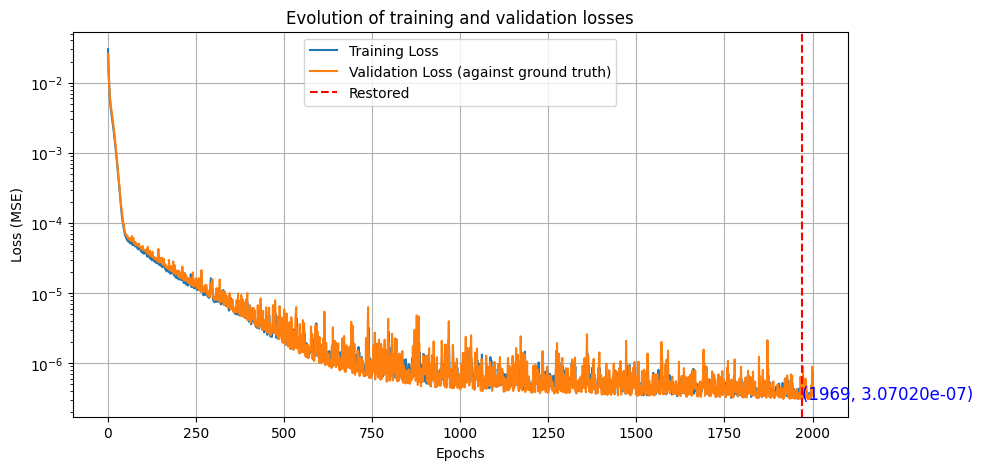

ValueError: Cannot take the length of shape with unknown rank.

In [16]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 150
start_from_epoch = 200
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-4, weight_decay=1e-2)
batch = 32
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/punn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(n_features, ))) #_ for batch dim
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^

punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#first column of Y is the label: acceleration
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train[:,0], validation_data=(X_val_norm, Y_val[:, 0]),
                                  batch_size=batch, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history, start_from_epoch)
punn_model.evaluate(x=X_val_norm, y=Y_val[:,0], batch_size=batch) #just to confirm final validation loss

In [17]:
punn_model.save("models/punn_model_3e-7.h5")

## PUNN predictions
offline integration for testing, in reality it would be real-time

## Training trajectory

Training trajectory (1) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3000
MSE/RMSE for acceleration: 3.06501e-07, 5.53626e-04
MSE/RMSE for velocity: 5.10871e-04, 2.26024e-02
MSE/RMSE for position: 4.11297e+00, 2.02805e+00
----


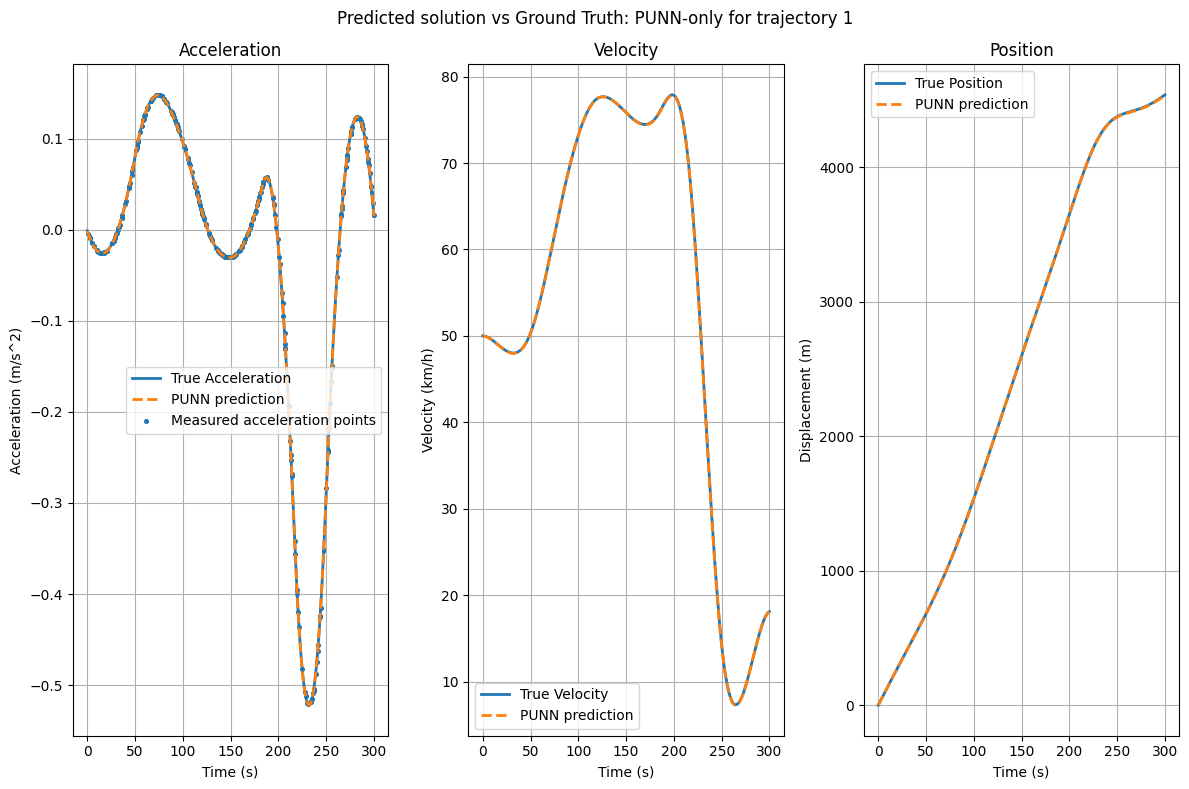

In [18]:
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
print("Training trajectory (" + str(train_id) + ") statistics: ")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=Y_train_traj)
print("----")
comparison_plot(t=t, true_data=Y_train_traj, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(train_id)
)


## Testing trajectory (generalization ability)

Testing trajectory (4) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3000
MSE/RMSE for acceleration: 5.60454e-04, 2.36739e-02
MSE/RMSE for velocity: 3.47427e-01, 5.89429e-01
MSE/RMSE for position: 1.28581e+03, 3.58582e+01
----


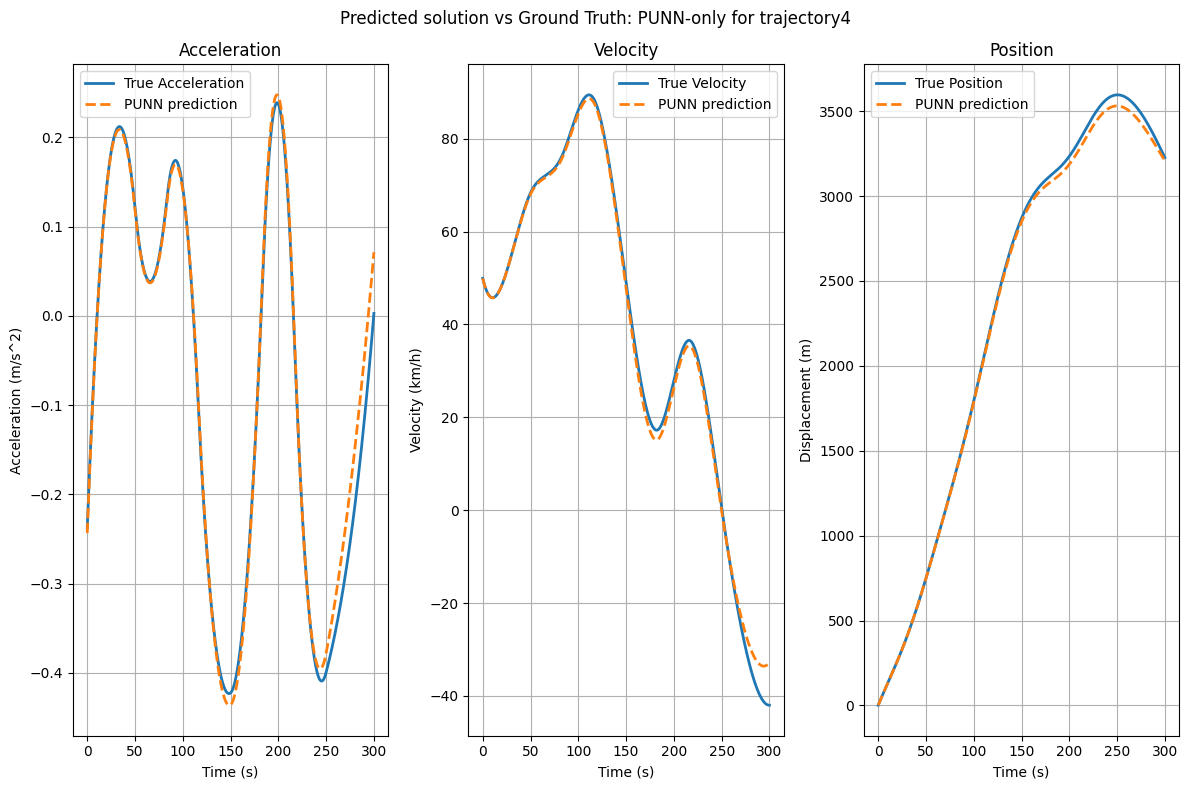

In [23]:
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
print("Testing trajectory (" + str(test_id) + ") statistics: ")
punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=Y_test_traj)
print("----")
comparison_plot(t=t, true_data=Y_test_traj, meas_data=None,
    pred_data=[(punn_test_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory" + str(test_id)
)

# PINN

## Combined Loss

In [ ]:
#not using this now
# def tf_cumulative_trapezoid(y, x):
#     """
#     Computes cumulative integral using the trapezoidal rule without breaking tensor computational graph
#     Both y and x must be 1D tensors of the same length.
#     """
#     dx = x[1:] - x[:-1]
#     areas = 0.5 * (y[1:] + y[:-1]) * dx
#     return tf.concat([[0.0], tf.math.cumsum(areas)], axis=0)


In [24]:
collocation_size = int(len(t)/4)
print("Number of collocation points: " + str(collocation_size))
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = input_interp[train_id] #get u from correct trajectory function
car.reset(x0)
df_c = simulate_traj(car=car, u_func=u_c, traj_id=train_id, t=t_c)
df_c.to_csv("data/train_traj_collocation.csv")
X_c = df_c[["t", "u", "v_true_m", "x_true"]].to_numpy()
X_c_norm = scaler_X.transform(X_c)

class PinnModel(Sequential):
    def __init__(self, joint_training: bool, phy_params: dict,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        if joint_training:
            #joint training of physics params
            """ self.c0 = self.add_weight(name="c0", shape=(), initializer="zeros",
                            trainable=True, dtype=tf.float32) #trainable -> added to tape.watch automatically according to docs
            self.c1 = self.add_weight(name="c1", shape=(), initializer="zeros",
                            trainable=True, dtype=tf.float32)
            self.phy_trainable = {"c0": self.c0, "c1": self.c1}
            #True values: c0 = 0.0075, c1 = 2*10**-4
            self.phy_trainable_true = phy_params """
        else:
            self.c0 = phy_params["c0"]
            self.c1 = phy_params["c1"]

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y0: np.ndarray, x0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, loss_weights: tuple[float, float, float], scaler_Y=None):
        super().__init__()

        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #IC
        self.y0 = y0 #acc
        #self.v0 = v0
        self.x0_norm = x0_norm
        #self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

        self.X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)

        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.t_c, self.u, self.v, self.x = (tf.constant(X_c_denorm[:, i]) for i in range(X_c_denorm.shape[1]))

    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car

        a = self.model(self.X_c_norm) #use PUNN to predict on collocation points
        a = tf.reshape(a, shape=([-1])) #flatten for shape matching
        #denormalize
        #a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denorm
        #a_phy = keras.ops.ravel(a_phy) #-> 1D
        #v_phy = self.v0 + tf_cumulative_trapezoid(a_phy, self.t_c) -> wrong, should use state

        #print(a.shape, sel\f.v.shape, self.u.shape, (self.v**2).shape)
        #resistive forces
        Fr = (self.model.c0 + self.model.c1 * self.v) * (car.m * g * np.cos(car.road_grade))
        Fa = (car.p * car.Cd * car.Af * self.v**2) / 2
        Fg = car.m * g * np.sin(car.road_grade)


        #physics residuals
        res = car.m * a - (self.u - Fr - Fa - Fg)  # Newton's law

        return tf.reduce_mean(tf.square(res))

    def boundary_loss(self):
        y0_pred = self.model(self.x0_norm[tf.newaxis, :]) #add batch shape
        sqr_diff = tf.square(y0_pred - self.y0)
        return tf.reduce_mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return (
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss +
            self.alpha_b * bound_loss
        )

Number of collocation points: 750


## Training

Epoch 1/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 74511.7734 - mse: 0.0317

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 60916.6016 - mse: 0.0266 - val_loss: 10726.8818 - val_mse: 0.0040 - learning_rate: 0.0100
Epoch 2/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 12537.9375 - mse: 0.0080 - val_loss: 4697.7661 - val_mse: 0.0091 - learning_rate: 0.0100
Epoch 3/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4582.3159 - mse: 0.0082 - val_loss: 3558.0693 - val_mse: 0.0103 - learning_rate: 0.0100
Epoch 4/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2183.3113 - mse: 0.0076 - val_loss: 1335.3989 - val_mse: 0.0047 - learning_rate: 0.0100
Epoch 5/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1335.4148 - mse: 0.0043

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 996.0864 - mse: 0.0032 - val_loss: 569.3525 - val_mse: 0.0026 - learning_rate: 0.0100
Epoch 6/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 569.3507 - mse: 0.0027

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 547.2668 - mse: 0.0023 - val_loss: 402.7584 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 7/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 402.7773 - mse: 0.0022

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 379.7036 - mse: 0.0019 - val_loss: 270.4395 - val_mse: 0.0013 - learning_rate: 0.0100
Epoch 8/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 270.4182 - mse: 0.0013

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 237.7858 - mse: 0.0013 - val_loss: 167.3090 - val_mse: 0.0012 - learning_rate: 0.0100
Epoch 9/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 167.3047 - mse: 7.7857e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 149.1594 - mse: 9.5437e-04 - val_loss: 97.6659 - val_mse: 8.8407e-04 - learning_rate: 0.0100
Epoch 10/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 97.6404 - mse: 9.3158e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 88.4329 - mse: 8.1931e-04 - val_loss: 57.2367 - val_mse: 7.1285e-04 - learning_rate: 0.0100
Epoch 11/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 57.2142 - mse: 5.8608e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 51.0935 - mse: 6.6145e-04 - val_loss: 32.5417 - val_mse: 6.1689e-04 - learning_rate: 0.0100
Epoch 12/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 32.5468 - mse: 5.3773e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 28.8573 - mse: 5.0106e-04 - val_loss: 18.4783 - val_mse: 5.6432e-04 - learning_rate: 0.0100
Epoch 13/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 18.4721 - mse: 4.3256e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 16.2927 - mse: 4.7723e-04 - val_loss: 10.6098 - val_mse: 5.1507e-04 - learning_rate: 0.0100
Epoch 14/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.6160 - mse: 5.1163e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.3605 - mse: 4.7706e-04 - val_loss: 6.2087 - val_mse: 4.9834e-04 - learning_rate: 0.0100
Epoch 15/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.2015 - mse: 4.0603e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.5532 - mse: 4.2923e-04 - val_loss: 3.8703 - val_mse: 4.8445e-04 - learning_rate: 0.0100
Epoch 16/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.8719 - mse: 4.6662e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.4998 - mse: 4.2241e-04 - val_loss: 2.5886 - val_mse: 4.7215e-04 - learning_rate: 0.0100
Epoch 17/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.5982 - mse: 6.1947e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.3988 - mse: 4.6851e-04 - val_loss: 1.9278 - val_mse: 4.6420e-04 - learning_rate: 0.0100
Epoch 18/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9062 - mse: 4.0529e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8263 - mse: 4.3783e-04 - val_loss: 1.5971 - val_mse: 4.5916e-04 - learning_rate: 0.0100
Epoch 19/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6084 - mse: 4.0406e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.5494 - mse: 4.1087e-04 - val_loss: 1.4368 - val_mse: 4.5547e-04 - learning_rate: 0.0100
Epoch 20/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4369 - mse: 4.1140e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.4053 - mse: 3.8372e-04 - val_loss: 1.3590 - val_mse: 4.5246e-04 - learning_rate: 0.0100
Epoch 21/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3326 - mse: 3.3653e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3360 - mse: 3.9076e-04 - val_loss: 1.3183 - val_mse: 4.4996e-04 - learning_rate: 0.0100
Epoch 22/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3150 - mse: 4.9075e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3056 - mse: 4.1836e-04 - val_loss: 1.2937 - val_mse: 4.4791e-04 - learning_rate: 0.0100
Epoch 23/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.3069 - mse: 4.6071e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2831 - mse: 4.0970e-04 - val_loss: 1.2756 - val_mse: 4.4620e-04 - learning_rate: 0.0100
Epoch 24/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.2550 - mse: 3.2721e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.2567 - mse: 3.4291e-04 - val_loss: 1.2601 - val_mse: 4.4470e-04 - learning_rate: 0.0100
Epoch 25/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.2546 - mse: 4.4312e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2537 - mse: 4.2423e-04 - val_loss: 1.2456 - val_mse: 4.4333e-04 - learning_rate: 0.0100
Epoch 26/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2275 - mse: 3.6024e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.2324 - mse: 4.0172e-04 - val_loss: 1.2315 - val_mse: 4.4207e-04 - learning_rate: 0.0100
Epoch 27/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.2292 - mse: 3.4601e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.2214 - mse: 3.9279e-04 - val_loss: 1.2177 - val_mse: 4.4086e-04 - learning_rate: 0.0100
Epoch 28/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.2273 - mse: 5.2747e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2120 - mse: 4.1741e-04 - val_loss: 1.2040 - val_mse: 4.3967e-04 - learning_rate: 0.0100
Epoch 29/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1786 - mse: 2.7015e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1873 - mse: 3.5293e-04 - val_loss: 1.1905 - val_mse: 4.3850e-04 - learning_rate: 0.0100
Epoch 30/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1561 - mse: 1.9960e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1734 - mse: 3.5735e-04 - val_loss: 1.1771 - val_mse: 4.3735e-04 - learning_rate: 0.0100
Epoch 31/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1730 - mse: 4.5820e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.1646 - mse: 3.9526e-04 - val_loss: 1.1639 - val_mse: 4.3620e-04 - learning_rate: 0.0100
Epoch 32/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1562 - mse: 3.9619e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.1574 - mse: 4.1410e-04 - val_loss: 1.1508 - val_mse: 4.3506e-04 - learning_rate: 0.0100
Epoch 33/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1699 - mse: 4.9240e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1432 - mse: 3.9521e-04 - val_loss: 1.1379 - val_mse: 4.3391e-04 - learning_rate: 0.0100
Epoch 34/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1063 - mse: 2.4062e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1230 - mse: 3.7235e-04 - val_loss: 1.1252 - val_mse: 4.3278e-04 - learning_rate: 0.0100
Epoch 35/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.1307 - mse: 5.2952e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.1176 - mse: 4.2627e-04 - val_loss: 1.1126 - val_mse: 4.3165e-04 - learning_rate: 0.0100
Epoch 36/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.0775 - mse: 2.8143e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0984 - mse: 3.6217e-04 - val_loss: 1.1001 - val_mse: 4.3053e-04 - learning_rate: 0.0100
Epoch 37/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1300 - mse: 5.4840e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1008 - mse: 4.6553e-04 - val_loss: 1.0878 - val_mse: 4.2942e-04 - learning_rate: 0.0100
Epoch 38/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.0764 - mse: 4.2277e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0760 - mse: 3.9106e-04 - val_loss: 1.0757 - val_mse: 4.2833e-04 - learning_rate: 0.0100
Epoch 39/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1027 - mse: 4.8361e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0782 - mse: 4.3099e-04 - val_loss: 1.0638 - val_mse: 4.2723e-04 - learning_rate: 0.0100
Epoch 40/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.0111 - mse: 1.4355e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0441 - mse: 3.3255e-04 - val_loss: 1.0519 - val_mse: 4.2616e-04 - learning_rate: 0.0100
Epoch 41/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.0543 - mse: 4.4211e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0421 - mse: 3.8957e-04 - val_loss: 1.0403 - val_mse: 4.2509e-04 - learning_rate: 0.0100
Epoch 42/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.0032 - mse: 1.7538e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0268 - mse: 3.4337e-04 - val_loss: 1.0288 - val_mse: 4.2403e-04 - learning_rate: 0.0100
Epoch 43/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.0284 - mse: 3.7328e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0248 - mse: 4.1134e-04 - val_loss: 1.0174 - val_mse: 4.2298e-04 - learning_rate: 0.0100
Epoch 44/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.0289 - mse: 4.5304e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0091 - mse: 3.7705e-04 - val_loss: 1.0062 - val_mse: 4.2195e-04 - learning_rate: 0.0100
Epoch 45/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.0055 - mse: 3.6452e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9944 - mse: 3.6241e-04 - val_loss: 0.9952 - val_mse: 4.2093e-04 - learning_rate: 0.0100
Epoch 46/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9583 - mse: 2.9796e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9799 - mse: 3.5543e-04 - val_loss: 0.9842 - val_mse: 4.1993e-04 - learning_rate: 0.0100
Epoch 47/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9726 - mse: 4.2224e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9745 - mse: 3.8187e-04 - val_loss: 0.9734 - val_mse: 4.1895e-04 - learning_rate: 0.0100
Epoch 48/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9642 - mse: 3.7677e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9653 - mse: 3.8907e-04 - val_loss: 0.9628 - val_mse: 4.1797e-04 - learning_rate: 0.0100
Epoch 49/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.9696 - mse: 4.7326e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9522 - mse: 3.7796e-04 - val_loss: 0.9522 - val_mse: 4.1703e-04 - learning_rate: 0.0100
Epoch 50/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.9573 - mse: 5.4781e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9447 - mse: 4.2049e-04 - val_loss: 0.9418 - val_mse: 4.1609e-04 - learning_rate: 0.0100
Epoch 51/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9527 - mse: 5.1173e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9314 - mse: 3.9418e-04 - val_loss: 0.9315 - val_mse: 4.1517e-04 - learning_rate: 0.0100
Epoch 52/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9331 - mse: 4.2514e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9248 - mse: 3.8459e-04 - val_loss: 0.9213 - val_mse: 4.1426e-04 - learning_rate: 0.0100
Epoch 53/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9236 - mse: 3.6140e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9114 - mse: 3.6007e-04 - val_loss: 0.9113 - val_mse: 4.1336e-04 - learning_rate: 0.0100
Epoch 54/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9126 - mse: 4.5347e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8995 - mse: 3.7425e-04 - val_loss: 0.9013 - val_mse: 4.1250e-04 - learning_rate: 0.0100
Epoch 55/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8622 - mse: 2.4632e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8822 - mse: 3.1486e-04 - val_loss: 0.8914 - val_mse: 4.1164e-04 - learning_rate: 0.0100
Epoch 56/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8497 - mse: 2.3766e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8733 - mse: 3.4355e-04 - val_loss: 0.8817 - val_mse: 4.1080e-04 - learning_rate: 0.0100
Epoch 57/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8834 - mse: 4.2305e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8750 - mse: 3.8287e-04 - val_loss: 0.8720 - val_mse: 4.0996e-04 - learning_rate: 0.0100
Epoch 58/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8758 - mse: 3.2430e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8609 - mse: 3.3734e-04 - val_loss: 0.8624 - val_mse: 4.0915e-04 - learning_rate: 0.0100
Epoch 59/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8614 - mse: 3.7096e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8526 - mse: 3.7650e-04 - val_loss: 0.8529 - val_mse: 4.0836e-04 - learning_rate: 0.0100
Epoch 60/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8414 - mse: 3.0929e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8460 - mse: 3.8485e-04 - val_loss: 0.8435 - val_mse: 4.0757e-04 - learning_rate: 0.0100
Epoch 61/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8332 - mse: 3.0111e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8309 - mse: 3.5086e-04 - val_loss: 0.8342 - val_mse: 4.0681e-04 - learning_rate: 0.0100
Epoch 62/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8734 - mse: 7.4047e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8260 - mse: 4.0857e-04 - val_loss: 0.8250 - val_mse: 4.0606e-04 - learning_rate: 0.0100
Epoch 63/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8333 - mse: 4.9634e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8171 - mse: 3.7977e-04 - val_loss: 0.8158 - val_mse: 4.0532e-04 - learning_rate: 0.0100
Epoch 64/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8333 - mse: 5.8494e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8060 - mse: 3.9048e-04 - val_loss: 0.8067 - val_mse: 4.0461e-04 - learning_rate: 0.0100
Epoch 65/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8220 - mse: 4.5989e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7997 - mse: 3.7658e-04 - val_loss: 0.7977 - val_mse: 4.0392e-04 - learning_rate: 0.0100
Epoch 66/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7683 - mse: 2.6289e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7768 - mse: 3.1533e-04 - val_loss: 0.7888 - val_mse: 4.0324e-04 - learning_rate: 0.0100
Epoch 67/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7665 - mse: 2.2616e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7824 - mse: 3.6567e-04 - val_loss: 0.7799 - val_mse: 4.0257e-04 - learning_rate: 0.0100
Epoch 68/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7504 - mse: 2.2065e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7645 - mse: 3.4513e-04 - val_loss: 0.7711 - val_mse: 4.0193e-04 - learning_rate: 0.0100
Epoch 69/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8010 - mse: 5.1505e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7662 - mse: 3.6527e-04 - val_loss: 0.7624 - val_mse: 4.0130e-04 - learning_rate: 0.0100
Epoch 70/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7577 - mse: 3.4724e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7513 - mse: 3.5174e-04 - val_loss: 0.7537 - val_mse: 4.0068e-04 - learning_rate: 0.0100
Epoch 71/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7820 - mse: 4.7879e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7446 - mse: 3.5211e-04 - val_loss: 0.7451 - val_mse: 4.0008e-04 - learning_rate: 0.0100
Epoch 72/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7128 - mse: 2.7758e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7313 - mse: 3.3586e-04 - val_loss: 0.7365 - val_mse: 3.9950e-04 - learning_rate: 0.0100
Epoch 73/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7625 - mse: 5.8663e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7327 - mse: 4.0721e-04 - val_loss: 0.7280 - val_mse: 3.9894e-04 - learning_rate: 0.0100
Epoch 74/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6937 - mse: 2.7045e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.7033 - mse: 2.9852e-04 - val_loss: 0.7196 - val_mse: 3.9840e-04 - learning_rate: 0.0100
Epoch 75/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7231 - mse: 3.1736e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7107 - mse: 3.4406e-04 - val_loss: 0.7112 - val_mse: 3.9787e-04 - learning_rate: 0.0100
Epoch 76/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7058 - mse: 3.3832e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6967 - mse: 3.4054e-04 - val_loss: 0.7029 - val_mse: 3.9737e-04 - learning_rate: 0.0100
Epoch 77/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6939 - mse: 2.6733e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6943 - mse: 3.5131e-04 - val_loss: 0.6947 - val_mse: 3.9687e-04 - learning_rate: 0.0100
Epoch 78/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6767 - mse: 2.5037e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6817 - mse: 3.3691e-04 - val_loss: 0.6865 - val_mse: 3.9639e-04 - learning_rate: 0.0100
Epoch 79/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6957 - mse: 3.4563e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6800 - mse: 3.4148e-04 - val_loss: 0.6783 - val_mse: 3.9592e-04 - learning_rate: 0.0100
Epoch 80/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6477 - mse: 3.0013e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6620 - mse: 3.3326e-04 - val_loss: 0.6702 - val_mse: 3.9547e-04 - learning_rate: 0.0100
Epoch 81/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6937 - mse: 6.3475e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6627 - mse: 3.9396e-04 - val_loss: 0.6622 - val_mse: 3.9504e-04 - learning_rate: 0.0100
Epoch 82/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6420 - mse: 3.0552e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6514 - mse: 3.5300e-04 - val_loss: 0.6542 - val_mse: 3.9463e-04 - learning_rate: 0.0100
Epoch 83/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6507 - mse: 3.4309e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6391 - mse: 3.1498e-04 - val_loss: 0.6463 - val_mse: 3.9422e-04 - learning_rate: 0.0100
Epoch 84/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5944 - mse: 8.3956e-05

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6303 - mse: 3.1697e-04 - val_loss: 0.6384 - val_mse: 3.9384e-04 - learning_rate: 0.0100
Epoch 85/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5894 - mse: 1.5364e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6199 - mse: 3.0474e-04 - val_loss: 0.6306 - val_mse: 3.9347e-04 - learning_rate: 0.0100
Epoch 86/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6462 - mse: 5.2653e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6239 - mse: 3.8417e-04 - val_loss: 0.6229 - val_mse: 3.9311e-04 - learning_rate: 0.0100
Epoch 87/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6226 - mse: 3.4252e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6156 - mse: 3.4712e-04 - val_loss: 0.6152 - val_mse: 3.9276e-04 - learning_rate: 0.0100
Epoch 88/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6254 - mse: 3.2816e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6054 - mse: 3.2250e-04 - val_loss: 0.6076 - val_mse: 3.9243e-04 - learning_rate: 0.0100
Epoch 89/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5678 - mse: 2.1071e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5976 - mse: 3.3851e-04 - val_loss: 0.6000 - val_mse: 3.9212e-04 - learning_rate: 0.0100
Epoch 90/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5752 - mse: 2.7552e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5857 - mse: 3.2395e-04 - val_loss: 0.5924 - val_mse: 3.9183e-04 - learning_rate: 0.0100
Epoch 91/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5670 - mse: 2.4798e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5769 - mse: 3.3501e-04 - val_loss: 0.5850 - val_mse: 3.9154e-04 - learning_rate: 0.0100
Epoch 92/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5759 - mse: 3.5195e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5738 - mse: 3.5175e-04 - val_loss: 0.5776 - val_mse: 3.9128e-04 - learning_rate: 0.0100
Epoch 93/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5691 - mse: 2.8701e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5656 - mse: 3.3080e-04 - val_loss: 0.5702 - val_mse: 3.9103e-04 - learning_rate: 0.0100
Epoch 94/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5423 - mse: 3.1653e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5621 - mse: 3.4728e-04 - val_loss: 0.5629 - val_mse: 3.9080e-04 - learning_rate: 0.0100
Epoch 95/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5610 - mse: 3.8152e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5569 - mse: 3.7500e-04 - val_loss: 0.5557 - val_mse: 3.9058e-04 - learning_rate: 0.0100
Epoch 96/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5321 - mse: 3.1363e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5415 - mse: 3.3194e-04 - val_loss: 0.5485 - val_mse: 3.9038e-04 - learning_rate: 0.0100
Epoch 97/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5481 - mse: 3.7008e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5417 - mse: 3.5082e-04 - val_loss: 0.5414 - val_mse: 3.9019e-04 - learning_rate: 0.0100
Epoch 98/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5628 - mse: 4.5592e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5383 - mse: 3.6896e-04 - val_loss: 0.5343 - val_mse: 3.9002e-04 - learning_rate: 0.0100
Epoch 99/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5210 - mse: 2.9578e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5215 - mse: 3.2572e-04 - val_loss: 0.5273 - val_mse: 3.8987e-04 - learning_rate: 0.0100
Epoch 100/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4917 - mse: 1.8184e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5149 - mse: 3.2667e-04 - val_loss: 0.5211 - val_mse: 3.8972e-04 - learning_rate: 0.0090
Epoch 101/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4863 - mse: 2.2194e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5016 - mse: 3.1805e-04 - val_loss: 0.5149 - val_mse: 3.8960e-04 - learning_rate: 0.0090
Epoch 102/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5222 - mse: 3.9676e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5105 - mse: 3.6221e-04 - val_loss: 0.5087 - val_mse: 3.8951e-04 - learning_rate: 0.0090
Epoch 103/2000
 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4878 - mse: 3.1187e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4941 - mse: 3.2817e-04 - val_loss: 0.5026 - val_mse: 3.8943e-04 - learning_rate: 0.0090
Epoch 104/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4762 - mse: 3.5151e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4870 - mse: 3.2944e-04 - val_loss: 0.4965 - val_mse: 3.8935e-04 - learning_rate: 0.0090
Epoch 105/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4878 - mse: 2.7181e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4844 - mse: 3.1490e-04 - val_loss: 0.4905 - val_mse: 3.8929e-04 - learning_rate: 0.0090
Epoch 106/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4908 - mse: 3.8985e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4799 - mse: 3.4221e-04 - val_loss: 0.4845 - val_mse: 3.8923e-04 - learning_rate: 0.0090
Epoch 107/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.4619 - mse: 2.7074e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.4724 - mse: 3.2957e-04 - val_loss: 0.4786 - val_mse: 3.8919e-04 - learning_rate: 0.0090
Epoch 108/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4551 - mse: 3.2098e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4624 - mse: 3.2623e-04 - val_loss: 0.4727 - val_mse: 3.8916e-04 - learning_rate: 0.0090
Epoch 109/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4340 - mse: 1.6590e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4554 - mse: 3.0617e-04 - val_loss: 0.4669 - val_mse: 3.8914e-04 - learning_rate: 0.0090
Epoch 110/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4276 - mse: 1.8657e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4474 - mse: 3.0353e-04 - val_loss: 0.4611 - val_mse: 3.8912e-04 - learning_rate: 0.0090
Epoch 111/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4517 - mse: 3.3317e-04 - val_loss: 0.4554 - val_mse: 3.8912e-04 - learning_rate: 0.0090
Epoch 112/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4479 - mse: 3.6694e-04 - val_loss: 0.4497 - val_mse: 3.8914e-04 - learning_rate: 0.0090
Epoch 113/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4298 - mse: 2.9815e-04 - val_loss: 0.4440 - val_mse: 3.8919e-04 - learning_rate: 0.0090
Epoch 114/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4296 - mse: 3.2127e-04 - val_loss: 0.4385 - val_mse: 3.8924e-04 - learning_rate: 0.0090
Epoch 115/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4378 - mse: 4.1338e-04 - val_loss: 0.4329 - val_mse: 3.8930e-04 - learning_rate: 0.0090
Epoch 116/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4281 - mse: 3.7547e-04 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 551.9030 - mse: 6.2950e-04 - val_loss: 560.1009 - val_mse: 2.7991e-04 - learning_rate: 0.0090
Epoch 131/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 304.5625 - mse: 4.5475e-04 - val_loss: 115.8956 - val_mse: 5.4215e-04 - learning_rate: 0.0090
Epoch 132/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 115.9128 - mse: 5.9075e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 85.2961 - mse: 3.9402e-04 - val_loss: 45.6909 - val_mse: 2.2446e-04 - learning_rate: 0.0090
Epoch 133/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 32.2047 - mse: 2.0824e-04 - val_loss: 17.4569 - val_mse: 3.0787e-04 - learning_rate: 0.0090
Epoch 134/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 11.5356 - mse: 2.2549e-04 - val_loss: 4.1139 - val_mse: 2.2696e-04 - learning_rate: 0.0090
Epoch 135/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.8974 - mse: 1.8873e-04 - val_loss: 0.6482 - val_mse: 2.5279e-04 - learning_rate: 0.0090
Epoch 136/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3517 - mse: 2.5471e-04 - val_loss: 0.5103 - val_mse: 2.5558e-04 - learning_rate: 0.0090
Epoch 137/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6650 - mse: 2.0160e-04 - val_loss: 0.5946 - val_mse: 2.4863e-04 - learning_rate: 0.0090
Epoch 138/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4779 - mse: 2.2303e-04 - va

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.1998 - mse: 2.2714e-04 - val_loss: 25.4534 - val_mse: 2.2078e-04 - learning_rate: 0.0090
Epoch 173/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 224.1902 - mse: 2.7746e-04 - val_loss: 570.0166 - val_mse: 2.4309e-04 - learning_rate: 0.0090
Epoch 174/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 570.0261 - mse: 2.5848e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 312.0452 - mse: 3.4785e-04 - val_loss: 78.4701 - val_mse: 2.1043e-04 - learning_rate: 0.0090
Epoch 175/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 94.1690 - mse: 2.2762e-04 - val_loss: 99.4600 - val_mse: 4.8071e-04 - learning_rate: 0.0090
Epoch 176/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 62.3030 - mse: 2.7574e-04 - val_loss: 9.7219 - val_mse: 2.6075e-04 - learning_rate: 0.0090
Epoch 177/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.7093 - mse: 1.9307e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 13.5447 - mse: 2.0423e-04 - val_loss: 8.1110 - val_mse: 1.9537e-04 - learning_rate: 0.0090
Epoch 178/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.1556 - mse: 1.7859e-04 - val_loss: 4.8607 - val_mse: 2.1712e-04 - learning_rate: 0.0090
Epoch 179/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.5554 - mse: 1.8459e-04 - val_loss: 0.3807 - val_mse: 2.2658e-04 - learning_rate: 0.0090
Epoch 180/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7381 - mse: 1.8961e-04 - val_loss: 0.4803 - val_mse: 2.3519e-04 - learning_rate: 0.0090
Epoch 181/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4854 - mse: 1.9564e-04 - val_loss: 0.4394 - val_mse: 2.3964e-04 - learning_rate: 0.0090
Epoch 182/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3263 - mse: 1.8598e-04 - val_loss: 0.2766 - val_mse: 2.3620e-04 - learning_rate: 0.0090
Epoch 183/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2400 - mse: 1.8089e-04 - val_lo

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.7672 - mse: 2.4167e-04 - val_loss: 204.7324 - val_mse: 1.9157e-04 - learning_rate: 0.0081
Epoch 227/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 514.8892 - mse: 4.5952e-04 - val_loss: 521.4731 - val_mse: 7.9566e-04 - learning_rate: 0.0081
Epoch 228/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 276.0393 - mse: 4.1656e-04 - val_loss: 105.3110 - val_mse: 4.5776e-04 - learning_rate: 0.0081
Epoch 229/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 64.2339 - mse: 3.2866e-04 - val_loss: 13.4194 - val_mse: 2.6802e-04 - learning_rate: 0.0081
Epoch 230/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 24.1844 - mse: 2.5029e-04 - val_loss: 21.8819 - val_mse: 2.0173e-04 - learning_rate: 0.0081
Epoch 231/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 11.5269 - mse: 2.3662e-04 - val_loss: 5.2654 - val_mse: 2.4217e-04 - learning_rate: 0.0081
Epoch 232/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.1021 - mse: 1.971

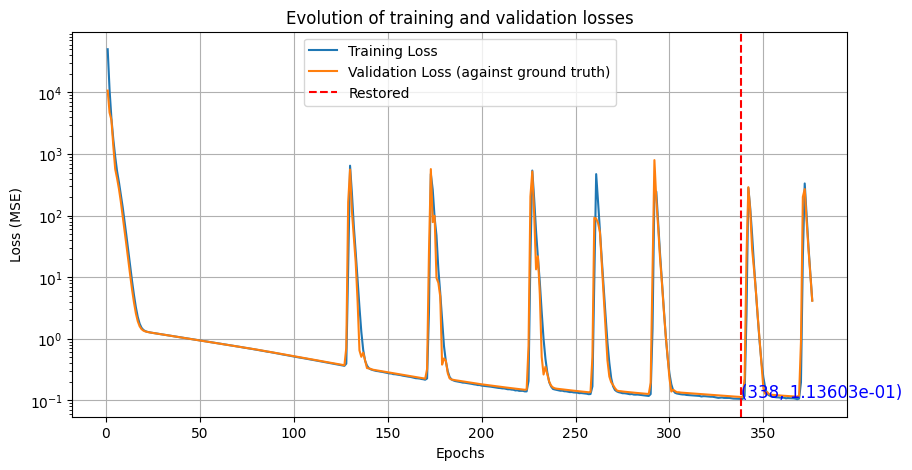

In [26]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "swish"
epochs = 2000
patience = 150
start_from_epoch = 200
schedule_tg = 100
metrics = ["mse"]
opt = Adam(learning_rate=1e-2, weight_decay=1e-3)
batch = 32
alpha_d = 1
alpha_p = 1
alpha_b = 0 # don't think this is needed when providing the states directly,
# as they serve as x0 -> a hard constraint for initial condition at each time step
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
joint_training = False
phy_params = {"c0": c0, "c1": c1}
#------
#NN architecture
pinn_model = PinnModel(joint_training=joint_training, phy_params=phy_params)
pinn_model.add(Input(shape=(n_features, )))
for _ in range(0, n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(1, activation="linear")) #output layer -> a^

#Custom PINN loss
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=None, loss_weights=alpha, x0_norm=x0_norm, y0=y0_true)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/pinn_model_forward.h5',
    monitor='val_mse', #track mse loss against true trajectory (not custom loss)
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

class CustomWeightLog(Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        for key, value in self.model.phy_trainable.items():
            logs[key] = value
    def on_train_end(self, logs=None):
        print(f"Custom trainable weights converged to:")
        for key, value in self.loss.train_params.items():
            true_value = self.model.phy_trainable_true[key]
            percentage = abs((value-true_value)/true_value)*100
            print(f"{key} = {value.numpy()}, true value = {true_value} ({percentage}% difference)")

custom_weight_logger = CustomWeightLog()

if joint_training:
    callbacks = [early_stopping, lr_scheduler, checkpoint, custom_weight_logger]
    #callbacks = [lr_scheduler, checkpoint, custom_weight_logger] #removed ES
else:
    callbacks = [early_stopping, lr_scheduler, checkpoint]

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train[:,0],
                                  validation_data=(X_val_norm, Y_val[:, 0]), #validating against true values here, not measurements
                                  batch_size=batch, epochs=epochs,
                                  callbacks=callbacks, verbose=True)
loss_plot(history_pinn_fwd.history, start_from_epoch)

In [ ]:
pinn_model.save("models/pinn_model_forward_best.h5")

# PUNN vs PINN

Training trajectory (1) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
3000
MSE/RMSE for acceleration: 3.06501e-07, 5.53626e-04
MSE/RMSE for velocity: 5.10871e-04, 2.26024e-02
MSE/RMSE for position: 4.11297e+00, 2.02805e+00
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
3000
MSE/RMSE for acceleration: 1.88970e-04, 1.37466e-02
MSE/RMSE for velocity: 4.80492e-01, 6.93175e-01
MSE/RMSE for position: 1.06729e+04, 1.03310e+02
----


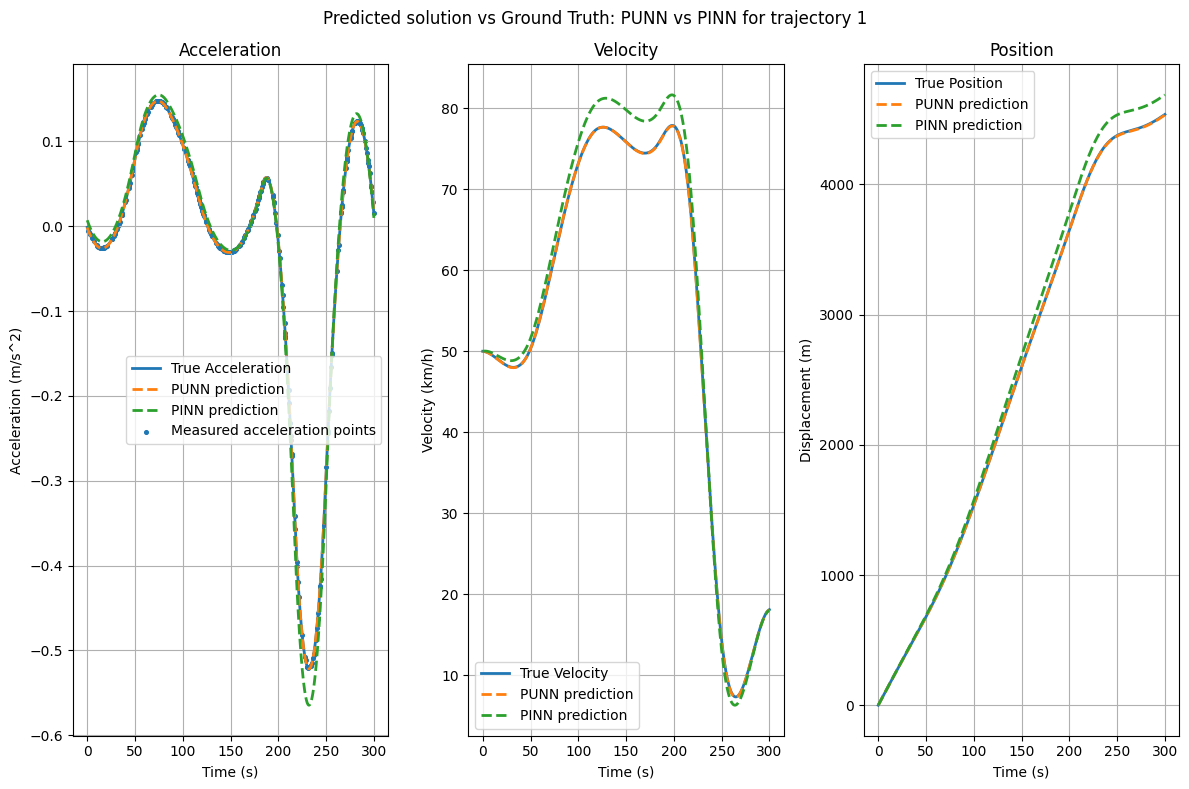

Testing trajectory (0) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
3000
MSE/RMSE for acceleration: 6.48865e-06, 2.54728e-03
MSE/RMSE for velocity: 6.87812e-02, 2.62262e-01
MSE/RMSE for position: 3.07630e+02, 1.75394e+01
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
3000
MSE/RMSE for acceleration: 1.15117e-04, 1.07293e-02
MSE/RMSE for velocity: 2.76309e-01, 5.25651e-01
MSE/RMSE for position: 2.57065e+03, 5.07016e+01
----


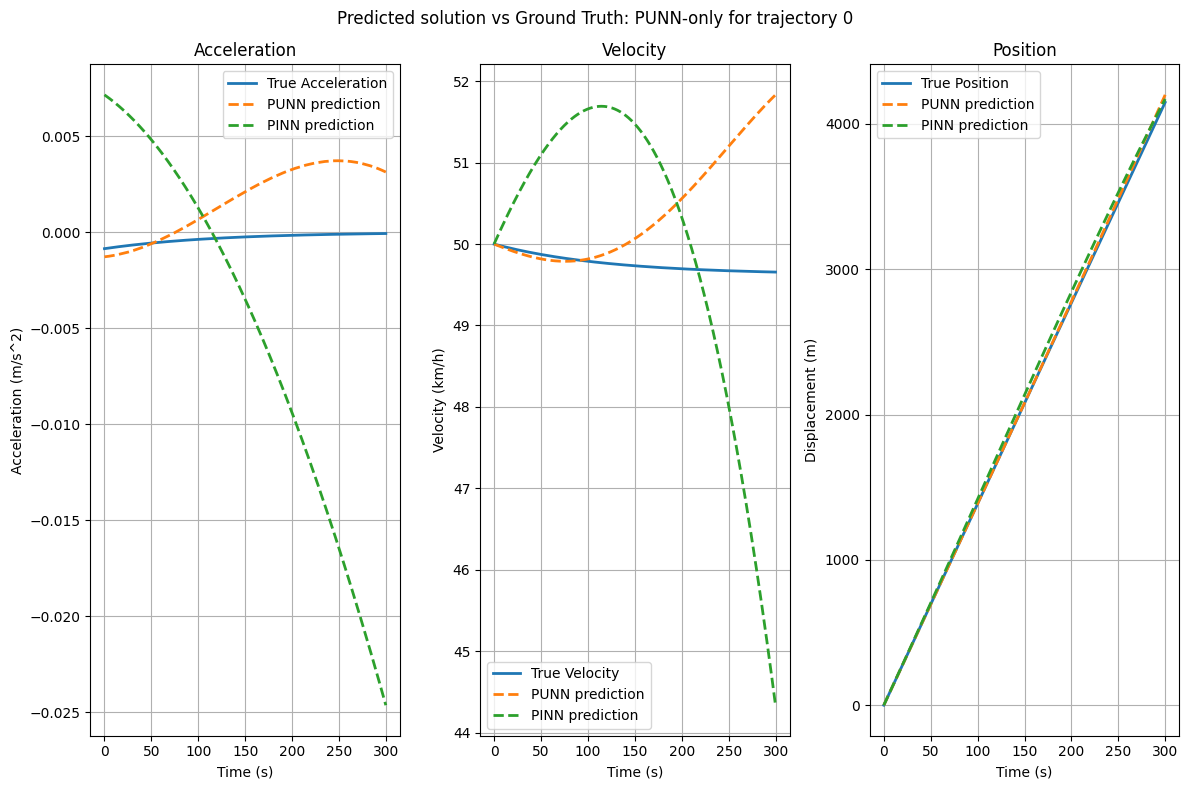

In [29]:
#punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction

#Load custom pinn model
''' custom_objects = {"PinnModel": PinnModel}
with custom_object_scope(custom_objects):
    pinn_model = load_model("models/pinn_model_forward_best.h5", compile=False)
print("Converged phy values:", pinn_model.phy_trainable)
 '''

# For train trajectory
print("Training trajectory (" + str(train_id) + ") statistics: ")
print("PUNN:")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=Y_train_traj)
print("PINN:")
pinn_train_traj_eval = evaluate_results(model=pinn_model, X_norm=X_norm, true_data=Y_train_traj)
print("----")
comparison_plot(t=t, true_data=Y_train_traj, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction"), (pinn_train_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(train_id)
)

# For test trajectory
print("Testing trajectory (" + str(test_id) + ") statistics: ")
print("PUNN:")
punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=Y_test_traj)
print("PINN:")
pinn_test_traj_eval = evaluate_results(model=pinn_model, X_norm=X_test_norm, true_data=Y_test_traj)
print("----")
comparison_plot(t=t, true_data=Y_test_traj, meas_data=None,
    pred_data=[(punn_test_traj_eval, "PUNN prediction"), (pinn_test_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(test_id)
)